In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
from random import sample

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import Lasso, HuberRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras import backend as be
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop, SGD
from keras.regularizers import l1
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

pd.set_option('display.max_columns',80)

2023-05-25 12:31:29.817608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# ***1- Initial Exploratory Data Analysis(EDA)***

Initial observation and investigation of the dataset revealed that it is a multivariate time series with multiple columns containing numerical values of different scales and some categorical columns. The dataset was loaded into a pandas data frame, and the first 5 rows were displayed to gain an initial understanding of the data.

Executing the info() method on the dataset further revealed that it consists of 23 features with 1458 samples. The dataset contains 17 features in float data type and 6 features in object data type. It is worth noting that the dataset has several missing values that need to be addressed before further analysis.

In [2]:
# Read Data in pandas dataframe
df = pd.read_csv('climate_dataset.csv')
df.head()

,date,emission,anomaly_value,upper_95_ci,lower_95_ci,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,All natural disasters,Drought,Earthquake,Extreme temperature,Extreme weather,Flood,Impact,Landslide,Mass movement (dry),Volcanic activity,Wildfire,global_avg_temp
0,1901-01-31,4.482107e+10,-0.075,-0.161,-0.008,-4.087,0.422,Berlin,Germany,52.24N,13.14E,5.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,-0.28
1,1901-02-28,4.482107e+10,-0.176,-0.259,-0.110,-3.598,0.951,Berlin,Germany,52.24N,13.14E,5.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,-0.06
2,1901-03-31,4.482107e+10,-0.272,-0.358,-0.210,2.945,0.354,Berlin,Germany,52.24N,13.14E,5.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,0.04
3,1901-04-30,4.482107e+10,-0.236,-0.317,-0.164,8.711,0.471,Berlin,Germany,52.24N,13.14E,5.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,-0.06
4,1901-05-31,4.482107e+10,-0.187,-0.259,-0.122,14.182,0.380,Berlin,Germany,52.24N,13.14E,5.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,-0.17


In [3]:
# Print number of categorical features
print(f'Number of categorical featuers: => {len(df.select_dtypes(object).columns)}')

# Print number of numerical features
print(f'Number of numerical featuers: => {len(df.select_dtypes(np.number).columns)}') 
print('='*80)

df.info()

Number of categorical featuers: => 6
Number of numerical featuers: => 17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           1458 non-null   object 
 1   emission                       1405 non-null   float64
 2   anomaly_value                  1429 non-null   float64
 3   upper_95_ci                    1429 non-null   float64
 4   lower_95_ci                    1429 non-null   float64
 5   AverageTemperature             1352 non-null   float64
 6   AverageTemperatureUncertainty  1352 non-null   float64
 7   City                           1353 non-null   object 
 8   Country                        1353 non-null   object 
 9   Latitude                       1353 non-null   object 
 10  Longitude                      1353 non-null   object 
 11  All natural disasters          1417

To gain a more comprehensive understanding of the dataset, an analysis of the dataframe was conducted. A function was implemented to determine the number of missing values, the number of unique values, and the data type of each feature. It was discovered that five columns, City, Country, Latitude, Longitude, and Impact, contained only one unique value. These features were deemed irrelevant to the prediction task as they do not vary across the dataset. Therefore, they were removed from the dataset.

Furthermore, it was found that several features, mostly related to disaster types, had over 30% missing values. These features may have limited predictive power and should be examined further before inclusion in the modeling process.

Lastly, it was observed that the global_avg_temp and date features were assigned the "Object" data type. Upon further inspection, it was determined that these features should have been assigned the numerical and datetime data types, respectively.

In [4]:
# Function to give information regarding shape, missing values, unique values, and types of a dataframe
def get_info(df):
    # Print shape of dataframe
    print(f'Shape of data ==>:\n Number of sampels: {df.shape[0]}\n\
 Number of features: {df.shape[1]}')
    # Calculate the number of missing values
    num_of_na = df.isna().sum()
    # Calculate the percentage of missing values
    percent_of_na = round((df.isna().sum()/len(df))*100,2)
     # Calculate the number of unique values
    num_of_unique =  df.nunique()
    # Create the dataframe to show the results
    df_info = pd.concat([num_of_na, percent_of_na , num_of_unique, df.dtypes], axis='columns',
                        keys=['num_of_missing_values', 'percentage_of_missing','num_of_unique_values' ,'types'])
    return df_info

df_info = get_info(df)
df_info

Shape of data ==>:
 Number of sampels: 1458
 Number of features: 23


,num_of_missing_values,percentage_of_missing,num_of_unique_values,types
date,0,0.00,1458,object
emission,53,3.64,118,float64
anomaly_value,29,1.99,842,float64
upper_95_ci,29,1.99,872,float64
lower_95_ci,29,1.99,833,float64
AverageTemperature,106,7.27,1325,float64
AverageTemperatureUncertainty,106,7.27,388,float64
City,105,7.20,1,object
Country,105,7.20,1,object
Latitude,105,7.20,1,object


# ***2- Data Preprocessing***
Preprocessing is an essential step in preparing data for machine learning models. In the case of a multivariate time series dataset, preprocessing may involve several steps such as handling missing values, transforming features, dealing with inconsistent or invalid data, and preparing the data for modeling. The aim of preprocessing is to prepare the data in a way that is appropriate for the specific modeling task and to maximize the performance of the machine learning algorithms.

To preprocess the dataset, we performed three main steps. Firstly, we dropped features with one unique value and dealt with the date column and global_avg_temp. Secondly, we checked for inconsistencies and non-continuity in the dates. Lastly, we handled missing values in the dataset.


### ***2-1 Handling Features with One Unique Value, Date Column, and Numeric Data Type***

In the first step of preprocessing, the features with only one unique value are removed from the dataset as they do not provide any useful information for modeling. The date column is transformed to the datetime format, and it is set as the index of the dataframe for easier manipulation of time-series data. Additionally, all the numeric features of the dataset are coerced into the numerical datatype using the to_numeric method to avoid any future errors that may arise from inconsistent data types.

In [5]:
# Extract column names that have only one unique value
col_with_unique_value = df_info.loc[df_info['num_of_unique_values'] == 1].index

# Drop these columns from the dataframe
df.drop(col_with_unique_value, axis='columns', inplace=True)

get_info(df)

Shape of data ==>:
 Number of sampels: 1458
 Number of features: 18


,num_of_missing_values,percentage_of_missing,num_of_unique_values,types
date,0,0.00,1458,object
emission,53,3.64,118,float64
anomaly_value,29,1.99,842,float64
upper_95_ci,29,1.99,872,float64
lower_95_ci,29,1.99,833,float64
AverageTemperature,106,7.27,1325,float64
AverageTemperatureUncertainty,106,7.27,388,float64
All natural disasters,41,2.81,76,float64
Drought,593,40.67,26,float64
Earthquake,89,6.10,31,float64


In [6]:
# Change the type of date column to datetime 
df['date'] = pd.to_datetime(df['date'])

# Make date as the index of data frame
df.set_index('date', inplace=True)

# Display head of Data
df.head()


,emission,anomaly_value,upper_95_ci,lower_95_ci,AverageTemperature,AverageTemperatureUncertainty,All natural disasters,Drought,Earthquake,Extreme temperature,Extreme weather,Flood,Landslide,Mass movement (dry),Volcanic activity,Wildfire,global_avg_temp
date,,,,,,,,,,,,,,,,,
1901-01-31,4.482107e+10,-0.075,-0.161,-0.008,-4.087,0.422,5.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,-0.28
1901-02-28,4.482107e+10,-0.176,-0.259,-0.110,-3.598,0.951,5.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,-0.06
1901-03-31,4.482107e+10,-0.272,-0.358,-0.210,2.945,0.354,5.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,0.04
1901-04-30,4.482107e+10,-0.236,-0.317,-0.164,8.711,0.471,5.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,-0.06
1901-05-31,4.482107e+10,-0.187,-0.259,-0.122,14.182,0.380,5.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,-0.17


In [7]:
# Make numeric values have numeric type
df = df.apply(pd.to_numeric, errors = 'coerce', downcast = 'float')

# Display dtypes of features
df.dtypes

emission                         float64
anomaly_value                    float32
upper_95_ci                      float32
lower_95_ci                      float32
AverageTemperature               float32
AverageTemperatureUncertainty    float32
All natural disasters            float32
Drought                          float32
Earthquake                       float32
Extreme temperature              float32
Extreme weather                  float32
Flood                            float32
Landslide                        float32
Mass movement (dry)              float32
Volcanic activity                float32
Wildfire                         float32
global_avg_temp                  float32
dtype: object

### ***2-2 Date Consistency Check*** 

To ensure data consistency, it is crucial to examine the dates in the time series dataframe to check for any inconsistency or non-consecutiveness in the data. Specifically, we need to verify that each sample corresponds to values measured in a single month.

To check for inconsistencies in the dataset, we group the dataframe by year and count the number of samples for each year. If there are more than 12 samples in a year, it indicates that we have either duplicate samples or multiple samples for a single month. Upon executing the code below, it is found that 29 years exhibit this characteristic. Additionally, we have observed that the dates in the dataframe are encoded with the end of the month, which could cause inconsistency in the indexes due to varying ending days of some months across different years.

To address these issues, we resample the dataframe by taking the mean for each month. This ensures that all years have 12 values, while maintaining the data integrity of years with 12 values. To avoid further inconsistencies, we encode each month with its first day.

To make sure that there are no gaps or overlaps in the data, we check the consecutiveness of the dates in the dataframe. This step is crucial to maintain the integrity of the time series data and prevent errors in subsequent analysis and modeling. To verify that, we create a series from the existing date and compare it to its sorted version. If the dates are consecutive, these two series should be identical. 


In [8]:
# Group data frame by year
df_by_year = df.groupby(df.index.year)

# Check years that have more than 12 values
count = {}
for year, data in df_by_year:
    if len(data) > 12:
        count[year] = count.get(year,12)+1

# Print the result
print(f'There are "{len(count)}" years having more than 12 rows.')

pd.DataFrame(count.values(),  index= count.keys(),columns = ['num_of_values']  )       
      

There are "29" years having more than 12 rows.


,num_of_values
1904,13
1908,13
1912,13
1916,13
1920,13
1924,13
1928,13
1932,13
1936,13
1940,13


In [9]:
# Resample dataframe by month
df_resample = df.resample('M').mean()

# Remove days at the end of month
df_resample.index  = df_resample.index.strftime('%Y-%m')

# Encode the indexes to have month with the first day
df_resample.index = pd.to_datetime(df_resample.index)

# Show new indexes
df_resample.index

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01',
               ...
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01'],
              dtype='datetime64[ns]', name='date', length=1429, freq=None)

In [10]:
# Checking data being consecutive

# Extract existing dates
existing_date =df_resample.index.to_series()

# Sort dates
sorted_date = existing_date.sort_values()

# Check whether existing dates equal sorted dates
print('Dates in the data set are consecutive') if (existing_date == sorted_date).unique() else\
print('Dates in the data set are not consecutive')

Dates in the data set are consecutive


### ***2-3 Handling Missing Values in the Dataset***

Handling missing values is a critical step in the data preprocessing pipeline, as it can significantly impact the accuracy of the model. In this step, we first identify the columns with the highest percentage of missing values, which are typically related to disaster-related features. Given that the absence of a disaster in a month implies that there were no related events, we can replace these missing values with zero.

For the remaining features with missing values, including "emission", "AverageTemperature", "AverageTemperatureUncertainty", and "global_avg_temp," we perform a more detailed analysis to determine the best approach. After extracting these features, we investigate the missing values, which are primarily located at the end of the dataset and account for about 5% of the total samples.

Although there are several techniques to fill in missing values, we choose to drop these samples because they represent a relatively small portion of the dataset and are unlikely to impact the overall performance of the model. Moreover, filling in these missing values artificially can introduce biases that may affect the accuracy of the model's predictions. Additionally, since the dataset is a time series, we cannot shuffle the data during the splitting phase. As a result, the artificially created data would be located in the test dataset and may pose a problem during the evaluation phase. Therefore, we believe that dropping these samples is the most appropriate approach.

In summary, our approach for handling missing values is to replace missing values for disaster-related features with zero and drop the samples with missing values for other features. This approach ensures that our model is built on the most accurate and reliable data available, and the evaluation of the model is not affected by artificially generated data.

In [11]:
# Extract information about missing values in the dataset and display them
get_info(df_resample).drop(['num_of_unique_values', 'types'], axis='columns')

Shape of data ==>:
 Number of sampels: 1429
 Number of features: 17


,num_of_missing_values,percentage_of_missing
emission,24,1.68
anomaly_value,0,0.00
upper_95_ci,0,0.00
lower_95_ci,0,0.00
AverageTemperature,77,5.39
AverageTemperatureUncertainty,77,5.39
All natural disasters,12,0.84
Drought,564,39.47
Earthquake,60,4.20
Extreme temperature,756,52.90


In [12]:
# Make a list of column names containing data related to natural disasters
disasters = ['All natural disasters','Drought', 'Earthquake','Extreme temperature','Extreme weather',
             'Flood', 'Landslide','Mass movement (dry)','Volcanic activity', 'Wildfire' ]

# Fill missing values in the natural disaster columns with zero, assuming that no disaster occurred in those months
df_resample[disasters] = df_resample[disasters].fillna(0)

# Display information about missing values in the dataset after filling the natural disaster columns
get_info(df_resample).drop(['num_of_unique_values', 'types'], axis='columns')


Shape of data ==>:
 Number of sampels: 1429
 Number of features: 17


,num_of_missing_values,percentage_of_missing
emission,24,1.68
anomaly_value,0,0.00
upper_95_ci,0,0.00
lower_95_ci,0,0.00
AverageTemperature,77,5.39
AverageTemperatureUncertainty,77,5.39
All natural disasters,0,0.00
Drought,0,0.00
Earthquake,0,0.00
Extreme temperature,0,0.00


In [13]:
# Extract remaining columns that have missing values 
columns = df_resample.isna().sum()
columns_with_missing = columns.loc[columns != 0]
columns_with_missing

emission                         24
AverageTemperature               77
AverageTemperatureUncertainty    77
global_avg_temp                  42
dtype: int64

In [14]:
# Loop through the columns with missing values and print the dates with missing values for each column
for column in columns_with_missing.index:
    mask = df_resample[column].isna()
    print(f'Feature "{column}" has {len(df_resample[mask].index)} missing values in following dates =>\
           \n {df_resample[mask].index.to_list}\n')

Feature "emission" has 24 missing values in following dates =>           
 <bound method IndexOpsMixin.tolist of DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01'],
              dtype='datetime64[ns]', name='date', freq=None)>

Feature "AverageTemperature" has 77 missing values in following dates =>           
 <bound method IndexOpsMixin.tolist of DatetimeIndex(['2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '20

In [15]:
# Display the number of samples and missing values in the dataset
print(f' Number of sampels equals to: {len(df_resample)} \n\
    and number of missing values at the end of dataset : {df_resample.isna().sum().max()}\n')

# Calculate and display the percentage of missing values in the dataset
print(f'Percentage of missing values to all samples => {round((df_resample.isna().sum().max()/len(df_resample))*100,2)}%')

 Number of sampels equals to: 1429 
    and number of missing values at the end of dataset : 77

Percentage of missing values to all samples => 5.39%


In [16]:
# Drop rows with missing values at the end of the dataset 
df_resample.dropna(inplace=True)

# Check if there are any missing values remaining in the dataset
df_resample.isna().sum()

emission                         0
anomaly_value                    0
upper_95_ci                      0
lower_95_ci                      0
AverageTemperature               0
AverageTemperatureUncertainty    0
All natural disasters            0
Drought                          0
Earthquake                       0
Extreme temperature              0
Extreme weather                  0
Flood                            0
Landslide                        0
Mass movement (dry)              0
Volcanic activity                0
Wildfire                         0
global_avg_temp                  0
dtype: int64

# ***3- Feature selection***
The feature selection process began with the addition of two new features, namely year and month, obtained from the date column. After adding the year and month features to the dataset, the next step is to visualize the relationship between the features and the target variable. By plotting them together, we can gain insight into any potential relationships between them, and identify any patterns or trends that may exist.

To select the most relevant features for our model, we will be using a combination of mutual information and the correlation matrix. Mutual information is a measure of the dependence between two variables that can capture more complicated relationships than linear relationships, and thus can be useful for detecting non-linear relationships between features and the target variable. On the other hand, the correlation matrix can help us detect collinearity between features, which is important because highly correlated features can negatively impact the performance of our model.

By combining these two methods, we can select a subset of features that are both relevant to the target variable and not highly correlated with each other. This will help us build a more accurate and robust model.



### ***3-1 Visual inspection***

Based on the visualization analysis, it appears that the target variable, anomaly_value, exhibits similar trends to certain features, namely upper_95_ci, lower_95_ci, and global average. Moreover, disaster type features, emission, and year also display a similar trend to the anomaly value. However, two features, namely AverageTemperature and AverageTemperatureUncertainty, as well as month, do not exhibit a clear direct relationship with the anomaly value.

In [17]:
# Set date as a column
df_resample = df_resample.reset_index()

# Make a new feature for year
df_resample['year'] = df_resample['date'].dt.year

# Make a new feature for year
df_resample['month'] = df_resample['date'].dt.month

# Set date as index
df_resample.set_index('date', inplace=True)

# Extract features
featuers = df_resample.drop('anomaly_value', axis='columns')

# Features name
featuers_name = featuers.columns

#Extract target variable
target = df_resample['anomaly_value']

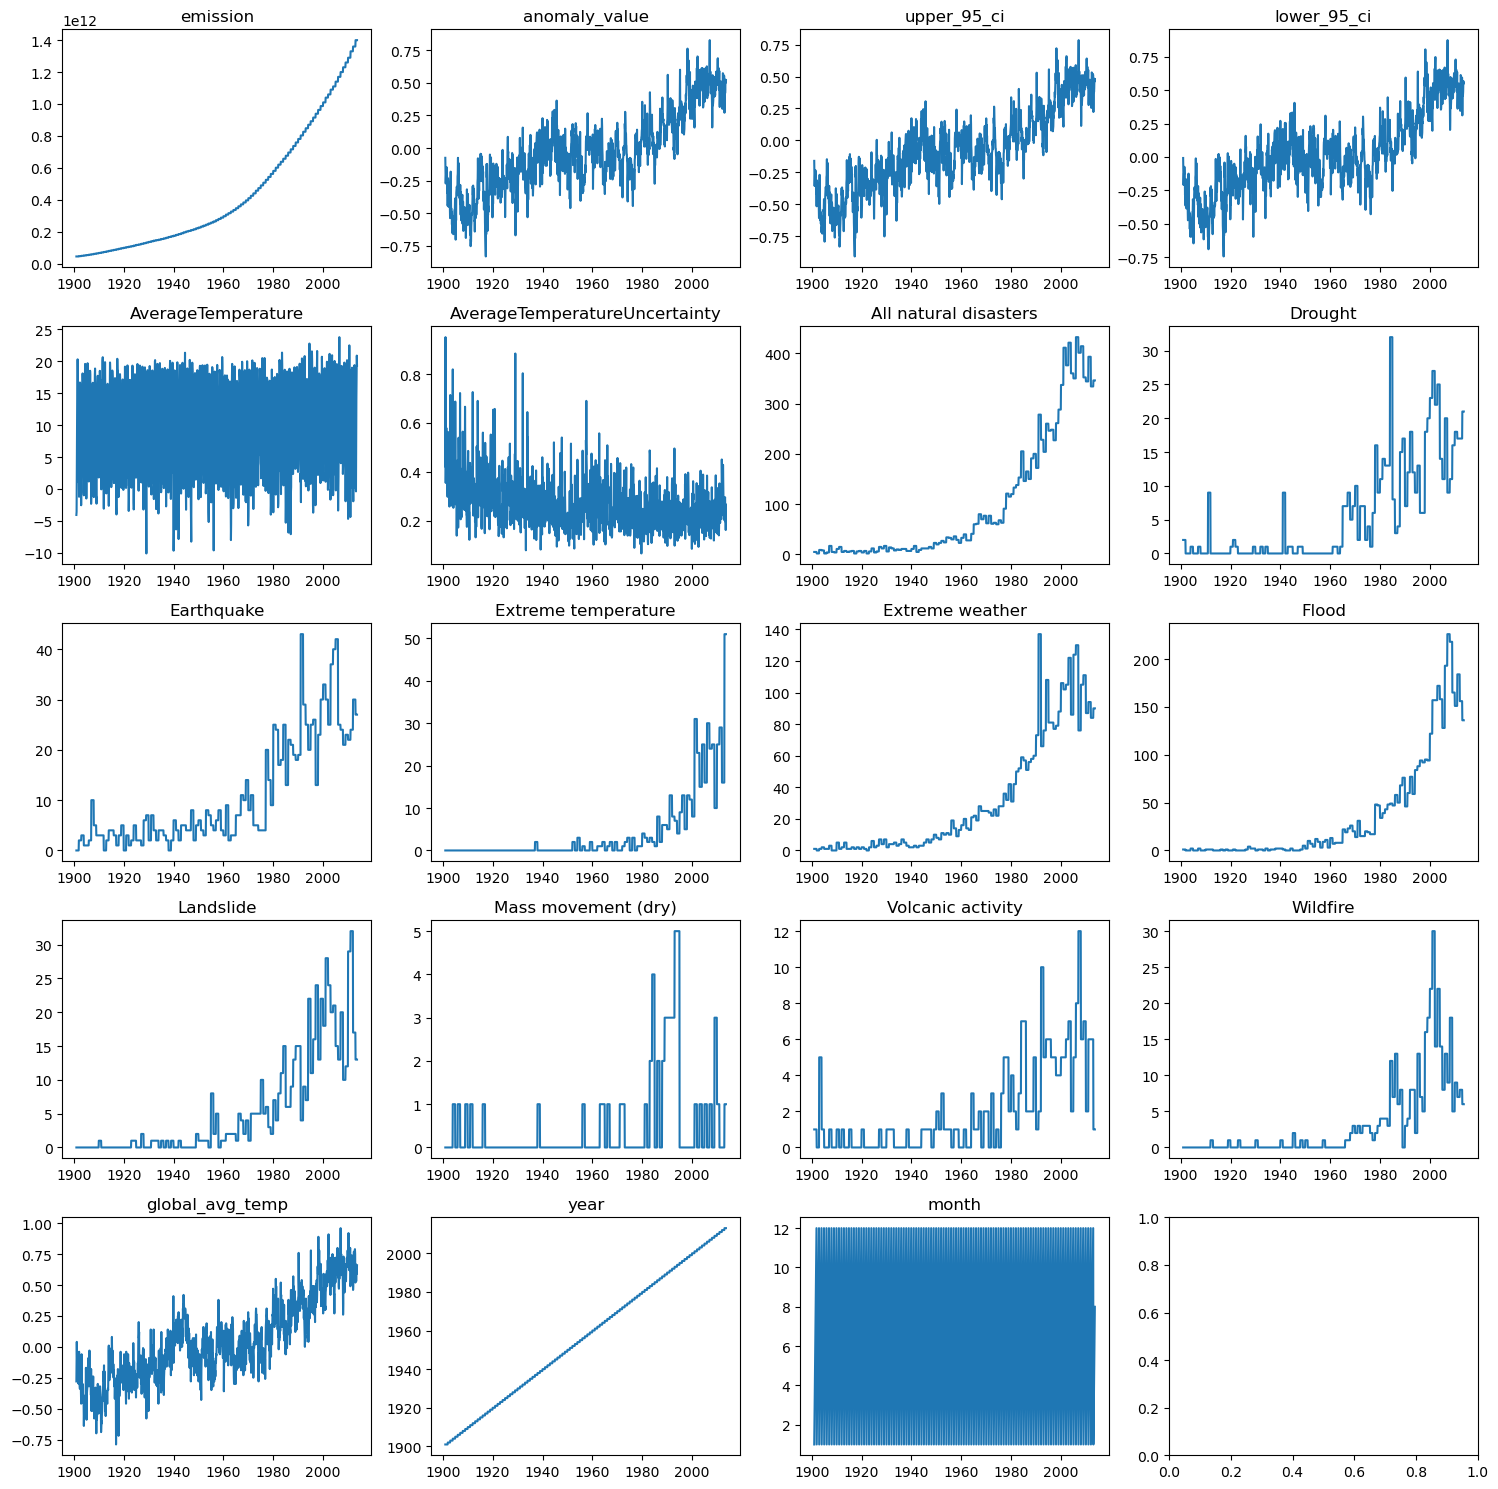

In [18]:
# Plot all features and target variable
fig, axs2 = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
for i, column in enumerate(df_resample.columns):
    row_idx = i // 4  # integer division to get row index
    col_idx = i % 4   # modulus division to get column index
    axs2[row_idx, col_idx].plot(df_resample[column])
    axs2[row_idx, col_idx].set_title(column)

plt.tight_layout()
plt.show()


### ***3-2 Mutual information***
https://medium.com/swlh/a-deep-conceptual-guide-to-mutual-information-a5021031fad0

The analysis of mutual information highlights the importance of certain features in relation to the target variable. Specifically, it was found that the upper_95_ci and lower_95_ci features provide the highest amount of information with respect to the target variable. This is followed by year, global_avg_temp, emission, and disaster type features.

It is worth noting that while mutual information is effective in detecting linear and non-linear relationships between each feature and the target variable, it assumes that the features are independent and is unable to handle multicollinearity between features. To address this limitation, a correlation matrix will be used to identify features that are highly correlated with one another. This approach will allow for the selection of features that are both informative in relation to the target variable and independent from one another.

In [19]:
# Calculate mutual information score
mutual_score1 = mutual_info_regression(featuers,target)

# Display results in a dataframe in descending order
pd.DataFrame(mutual_score1.T, columns=['MI'], index=featuers_name).sort_values('MI', ascending= False)

,MI
upper_95_ci,3.118892
lower_95_ci,3.117404
year,0.945687
global_avg_temp,0.917951
emission,0.915559
Extreme weather,0.751202
Flood,0.725922
Extreme temperature,0.720290
All natural disasters,0.707846
Landslide,0.682220


### ***3-3 Correlation Matrix***

Based on the correlation analysis on target variable, the linear correlation between each feature and the target variable has been examined. It is worth noting that the features, lower_95_ci, upper_95_ci, global_avg_temp, emission, year, and All natural disasters, show the highest correlation with the target variable, respectively, followed by the other disaster types. However, this analysis cannot capture the colinearity between features, which can lead to issues in feature selection. Therefore, it is recommended to examine all correlations together to gain a better understanding of how to select features.

Upon examining the correlations between features, it was found that the two feature sets of ["upper_95_ci" and "lower_95_ci"] and ['emission', 'All natural disasters'] are highly correlated with each other. This means that using each of these features in the final model, we can drop the other one to avoid redundancy. Additionally, the feature "All natural disasters" is the sum of all other disaster type features. Therefore, by including "All natural disasters" in the model, we can drop the other individual disaster type features to avoid multicollinearity issues.

It is clear that certain sets of features can be selected for our final model without significantly affecting its performance. These feature sets can be derived from the list of features which includes 'emission' or 'All natural disasters', 'upper_95_ci' or 'lower_95_ci', AverageTemperature, AverageTemperatureUncertainty, global_avg_temp, year, and month. Moreover features such as "AverageTemperature", "AverageTemperatureUncertainty", and "month" have low correlation with the target variable, and hence can be good candidates for exclusion while creating our models.


In [20]:
# Calculate the correlation of features to target variable
corr_to_target = df_resample.corr(numeric_only=True)['anomaly_value']
# Show results in Descending order
corr_to_target.abs().sort_values(ascending=False)

anomaly_value                    1.000000
lower_95_ci                      0.997677
upper_95_ci                      0.997598
global_avg_temp                  0.912570
emission                         0.832753
year                             0.832520
All natural disasters            0.798334
Extreme weather                  0.785045
Flood                            0.770781
Earthquake                       0.744234
Landslide                        0.730548
Extreme temperature              0.688550
Drought                          0.664512
Wildfire                         0.647338
Volcanic activity                0.598444
AverageTemperatureUncertainty    0.320141
Mass movement (dry)              0.237613
AverageTemperature               0.070414
month                            0.028082
Name: anomaly_value, dtype: float64

,emission,upper_95_ci,lower_95_ci,AverageTemperature,AverageTemperatureUncertainty,All natural disasters,Drought,Earthquake,Extreme temperature,Extreme weather,Flood,Landslide,Mass movement (dry),Volcanic activity,Wildfire,global_avg_temp,year,month
emission,1.000000,0.842109,0.819348,0.057597,-0.301457,0.968768,0.821271,0.881313,0.833655,0.948523,0.938472,0.888105,0.359779,0.764841,0.773879,0.874483,0.932028,-0.008840
upper_95_ci,0.842109,1.000000,0.991128,0.069348,-0.330257,0.799374,0.674435,0.750489,0.679117,0.790620,0.767464,0.733407,0.247638,0.605657,0.646588,0.916535,0.857772,0.033506
lower_95_ci,0.819348,0.991128,1.000000,0.071450,-0.311850,0.792714,0.650380,0.733138,0.693800,0.775230,0.769674,0.724138,0.226039,0.588013,0.643675,0.903413,0.805713,0.026594
AverageTemperature,0.057597,0.069348,0.071450,1.000000,-0.146605,0.059507,0.050699,0.048454,0.048513,0.057758,0.059069,0.055520,0.029120,0.050621,0.046951,0.053538,0.052210,0.221488
AverageTemperatureUncertainty,-0.301457,-0.330257,-0.311850,-0.146605,1.000000,-0.261952,-0.215677,-0.273587,-0.191552,-0.279485,-0.235570,-0.239422,-0.114050,-0.207180,-0.225479,-0.319799,-0.385610,-0.118520
All natural disasters,0.968768,0.799374,0.792714,0.059507,-0.261952,1.000000,0.849698,0.900612,0.872553,0.966473,0.975896,0.893297,0.355014,0.790313,0.843269,0.840023,0.853163,-0.006667
Drought,0.821271,0.674435,0.650380,0.050699,-0.215677,0.849698,1.000000,0.821556,0.684702,0.821973,0.774482,0.780201,0.411187,0.704213,0.797847,0.716061,0.756885,-0.007104
Earthquake,0.881313,0.750489,0.733138,0.048454,-0.273587,0.900612,0.821556,1.000000,0.720380,0.917074,0.814476,0.772996,0.413426,0.706757,0.778565,0.789218,0.815225,-0.005239
Extreme temperature,0.833655,0.679117,0.693800,0.048513,-0.191552,0.872553,0.684702,0.720380,1.000000,0.785339,0.886732,0.765493,0.165214,0.575412,0.718572,0.713082,0.674975,-0.019652
Extreme weather,0.948523,0.790620,0.775230,0.057758,-0.279485,0.966473,0.821973,0.917074,0.785339,1.000000,0.901485,0.848038,0.441585,0.753950,0.792304,0.829033,0.867574,-0.005411


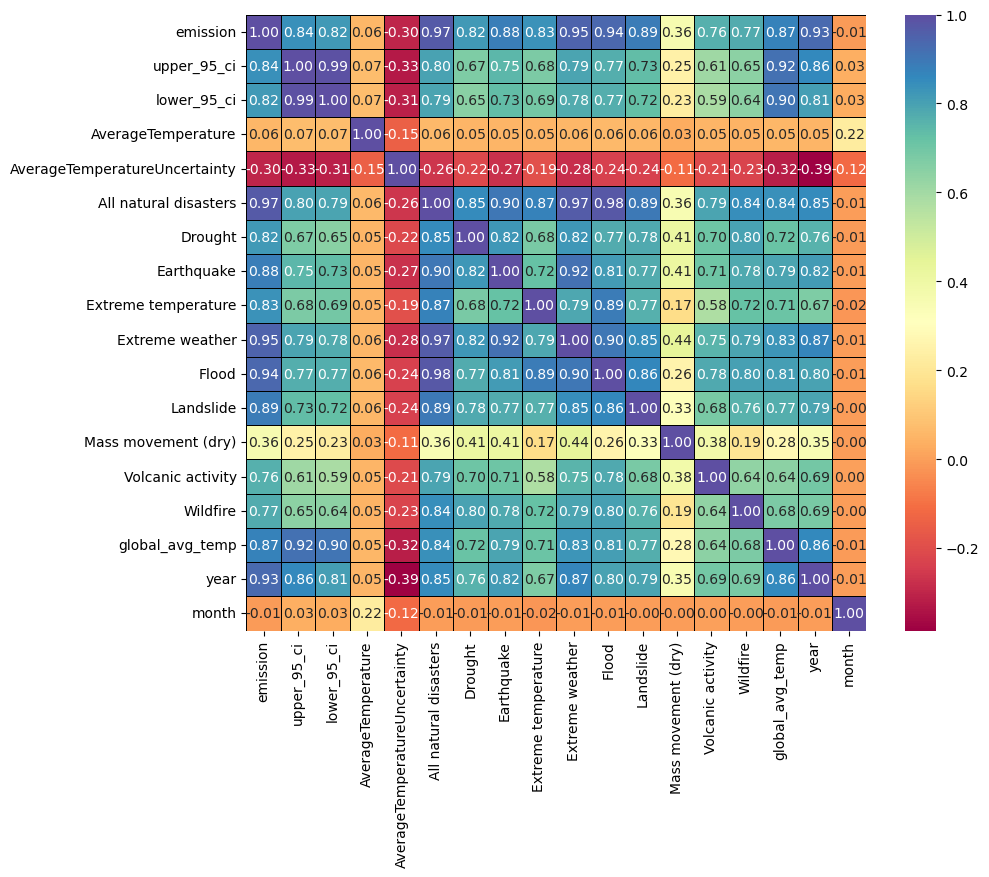

In [21]:
# Create correlation matrix for features
feature_corr = featuers.corr(numeric_only=True)

# Display correlation matrix
display(feature_corr)

# Plot correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr, annot=True,fmt='0.2f', linewidths=0.5, linecolor='Black', cmap='Spectral')
plt.show()


In [22]:
# Loop through features correlation matrix to detect highly correlated features

# Define a threshold for linearity
linear_corr_threshold = 0.95

high_corr = []
for column in feature_corr.columns:
    for idx in feature_corr.index:
        if feature_corr.loc[idx,column] > linear_corr_threshold  and [idx,column] not in high_corr and column != idx:
            high_corr.append([column,idx])

print('List of highly correlated features =>')
high_corr

List of highly correlated features =>


[['emission', 'All natural disasters'],
 ['upper_95_ci', 'lower_95_ci'],
 ['All natural disasters', 'Extreme weather'],
 ['All natural disasters', 'Flood']]

In [23]:
# Make list of desaster type features excluding "All natural disasters"
disaster_in_detail = [d for d in disasters if d != 'All natural disasters']

# Calculate monthly sum of disasters 
sum_of_disasters = df_resample[disaster_in_detail].sum(axis=1)

# Chech equality of All natural disasters to other disaster-type features
check_disasters = (sum_of_disasters == df_resample['All natural disasters']).sum()

print('The feature "All natural disasters" is sum of all other disaster types features')\
    if check_disasters == len(df_resample)\
    else print('The feature "All natural disasters" is not sum of all other disaster-types features')

The feature "All natural disasters" is sum of all other disaster types features


### 3-4 Feature Selection Results
In order to determine the appropriate set of features for the final model, we utilized the output of mutual information to select relevant features, while also considering the output of the correlation matrix to mitigate the issue of collinearity between features.

Based on the output of mutual information, "upper_95_ci" was selected as the first feature, and "lower_95_ci" was excluded from the final features due to high linear correlation with "upper_95_ci". The next two features were "year" and "global_avg_temp" based on mutual information scores. "Emission" and "All natural disasters" were selected as the fifth and sixth features, respectively, as they had high mutual information scores.

To avoid collinearity between features, the output of correlation matrix was used to determine whether to include "emission" or "All natural disasters" in the final feature set. "AverageTemperature", "AverageTemperatureUncertainty", and "month" were excluded from the final feature set as both mutual information and correlation matrix indicated low importance for these features.

It is worth noting that our final feature set was chosen from the following sets that are sorted based on how informative they are to predict anomoly values:
- 1- upper_95_ci, global_avg_temp, year, emission
- 2- upper_95_ci, global_avg_temp, year, All natural disasters
- 3- lower_95_ci, global_avg_temp, year, emission
- 4- lower_95_ci, global_avg_temp, year, All natural disasters

Among these sets, we chose the **First** one because the analysis showed this set is the most informative one.

In conclusion, our final feature set consists of "upper_95_ci", "global_avg_temp", "year", and "emission", selected based on the outputs of both mutual information and correlation matrix analyses. This feature set is expected to provide the best performance in predicting the target variable while avoiding the collinearity between features.

In [24]:
# Display final Dataframe
final_df = df_resample[['upper_95_ci','global_avg_temp','year','emission','anomaly_value']]
final_df

,upper_95_ci,global_avg_temp,year,emission,anomaly_value
date,,,,,
1901-01-01,-0.161,-0.28,1901,4.482107e+10,-0.075
1901-02-01,-0.259,-0.06,1901,4.482107e+10,-0.176
1901-03-01,-0.358,0.04,1901,4.482107e+10,-0.272
1901-04-01,-0.317,-0.06,1901,4.482107e+10,-0.236
1901-05-01,-0.259,-0.17,1901,4.482107e+10,-0.187
...,...,...,...,...,...
2013-04-01,0.378,0.53,2013,1.400000e+12,0.421
2013-05-01,0.407,0.62,2013,1.400000e+12,0.450
2013-06-01,0.483,0.65,2013,1.400000e+12,0.525


# ***4- Feature Engineering***

Feature engineering is a crucial step in time series analysis as it involves transforming raw data into a form that is suitable for machine learning models. In this section, we aim to detect correlations between each feature and its lags to determine which lags can be used to predict the target variable. To ensure that our data is suitable for this analysis, we will first test the stationarity of the data using the Augmented Dickey-Fuller test, which is a statistical test that assesses whether a time series has a unit root. If the data is found to be non-stationary, we will apply a stationary transformation to the data to make it suitable for further analysis. Once the data has been made stationary, we will examine the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

By analyzing the ACF and PACF plots, we can identify the significant lags for each feature that can be used to predict the target variable. These lags can then be included as additional features in our model to improve its performance.

### ***4-1 Preform feature enginearing analysis***

In the first step, we used the augmented Dickey Fuller test to determine whether our features and target variable were stationary. The test showed that all features and the target variable were not stationary. To make them stationary, we applied the first difference to the features and the target variable.(we have to preform first differencing to emission 2 times)

We then wrote a function that plotted each feature and its stationary version side by side, as well as its ACF and PACF. We applied this function to all features and the target variable.

The ACF and PACF plots for the target variable (anomaly value) and the feature upper_95_ci showed correlations at lag 1 and 2, indicating that these two had a weak correlation to their lags beyond 2 lags.

For global_avg_temp, the ACF showed significant correlations at lag 1, while the PACF showed significant correlations up to lag 5. This suggests that global_avg_temp has a significant correlation with its own lags up to 5 lags.

For All natural disasters, since the nature of the data is monthly, we observe that there is a strong correlation at every 12th lag for both ACF and PACF. This suggests that there is a seasonality pattern in the data, with a 12-month period. This makes sense since many natural disasters tend to occur during certain seasons.

Finally, the feature year, which only contains the year and repeats each year 12 times, showed a strong correlation with its own lags at every 12th lag in the ACF and all previous 12 lags in the PACF. This makes sense since the feature year is essentially a cyclical feature with a period of 12, representing the repeating annual cycle. The strong correlation with the 12th lag in the ACF suggests that the feature year is highly correlated with its own value from the previous year, while the strong correlation in the PACF at all previous 12 lags suggests that the feature year is highly correlated with its own value from the previous 12 years.

In [25]:
#Checking for being stationary
for column in final_df.columns:
    result = adfuller(final_df[column])
    print(f'"{column}" is stationary') if result[1] < 0.05 else print(f'"{column}" is not stationary')

"upper_95_ci" is not stationary
"global_avg_temp" is not stationary
"year" is not stationary
"emission" is not stationary
"anomaly_value" is not stationary


In [26]:
# make new stationary dataframe
stationary_data = final_df.diff(1).dropna()
for column in stationary_data.columns:
    result = adfuller(stationary_data[column])
    print(f'"{column}" is stationary') if result[1] < 0.05 else print(f'"{column}" is not stationary')

"upper_95_ci" is stationary
"global_avg_temp" is stationary
"year" is stationary
"emission" is not stationary
"anomaly_value" is stationary


In [27]:
# Make emission stationary
emission_stationary = stationary_data['emission'].diff(1).dropna()

# Drop the non-stationary emission from stationary data set
stationary_data = stationary_data.drop('emission', axis='columns')

# Keep first anomaly value befor excluding the first row
first_anomaly_values = final_df.loc[stationary_data.index[0],'anomaly_value']

# Concat srationary emission to stationary data set
stationary_data = pd.concat([stationary_data[1:], emission_stationary], axis='columns')

# check for stationarity of features
for column in stationary_data.columns:
    result = adfuller(stationary_data[column])
    print(f'"{column}" is stationary') if result[1] < 0.05 else print(f'"{column}" is not stationary')

"upper_95_ci" is stationary
"global_avg_temp" is stationary
"year" is stationary
"anomaly_value" is stationary
"emission" is stationary


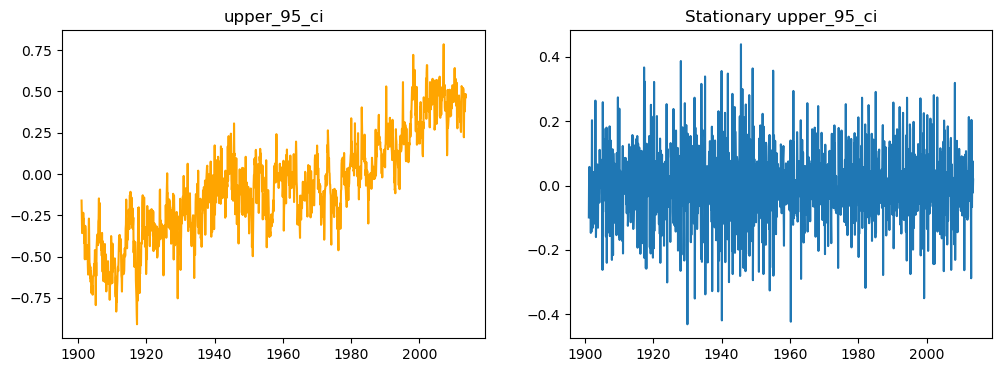

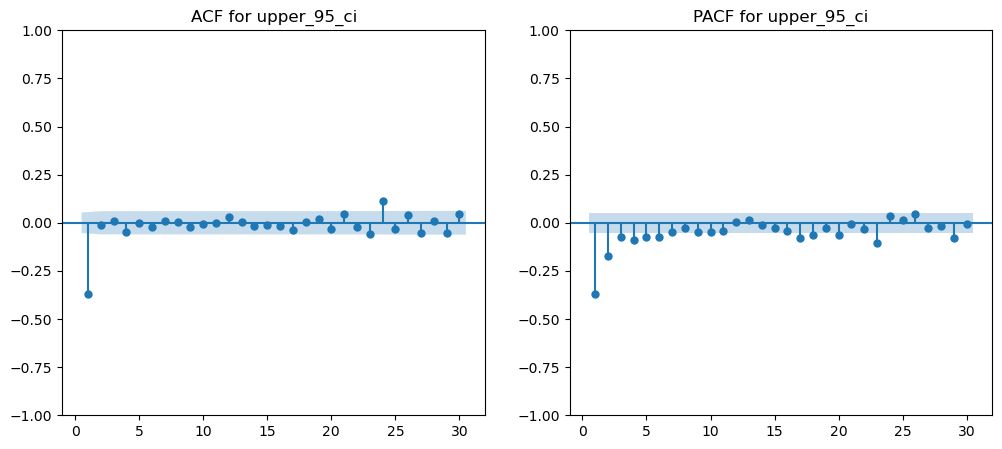

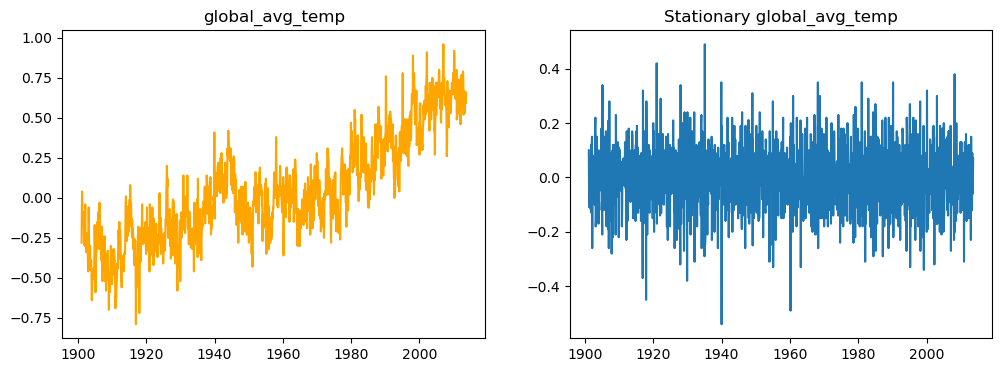

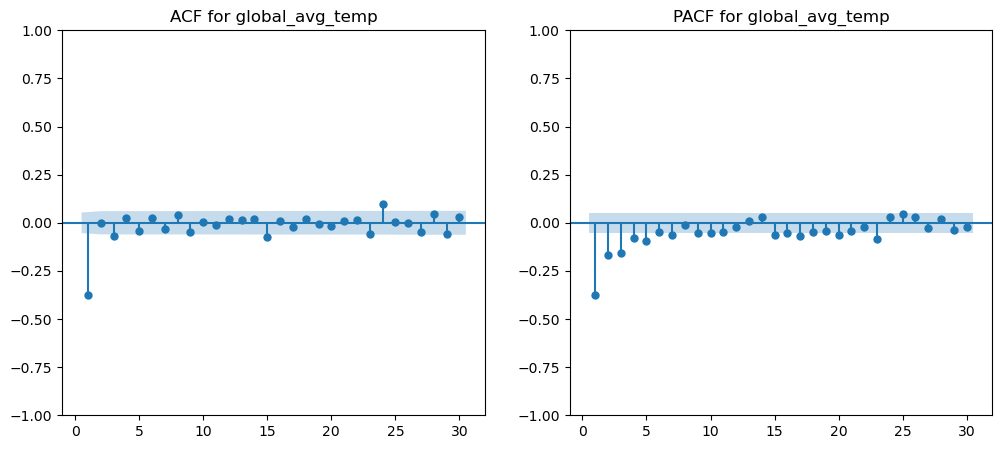

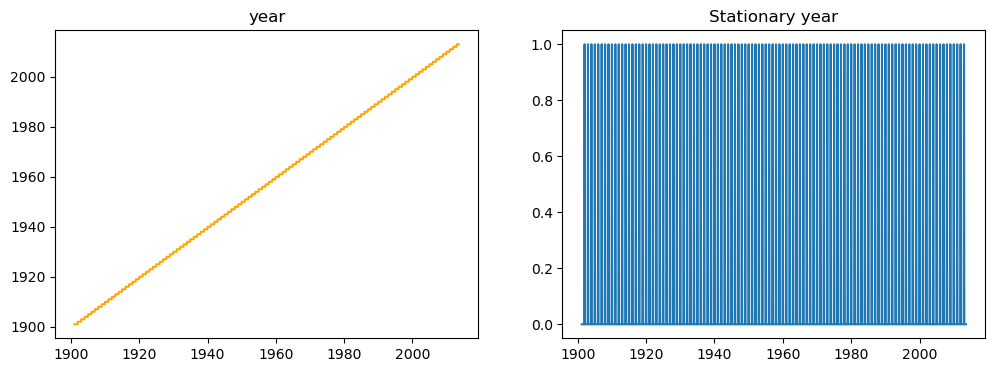

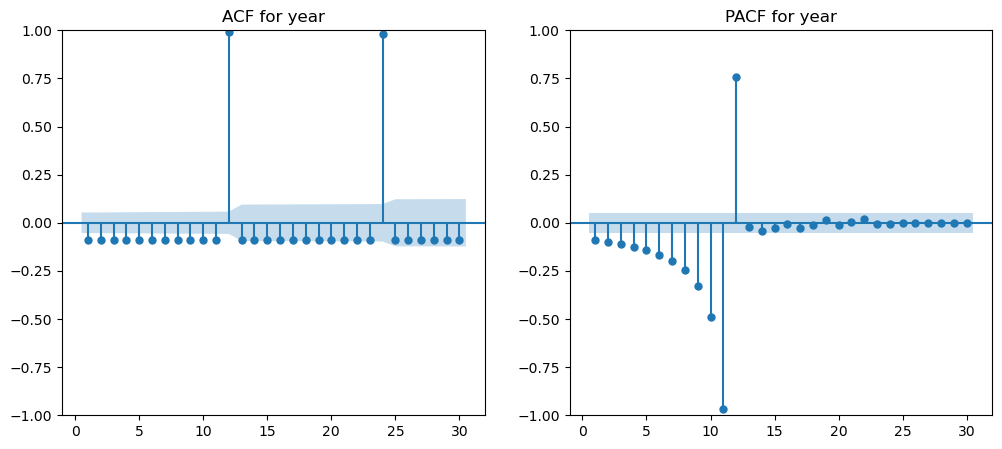

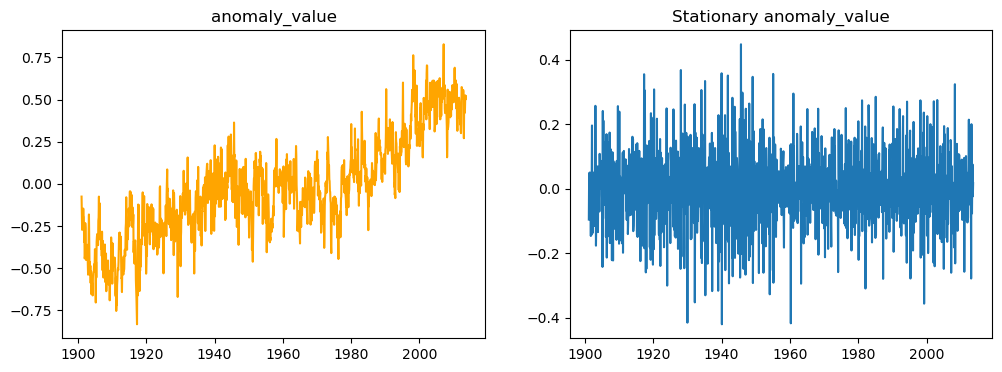

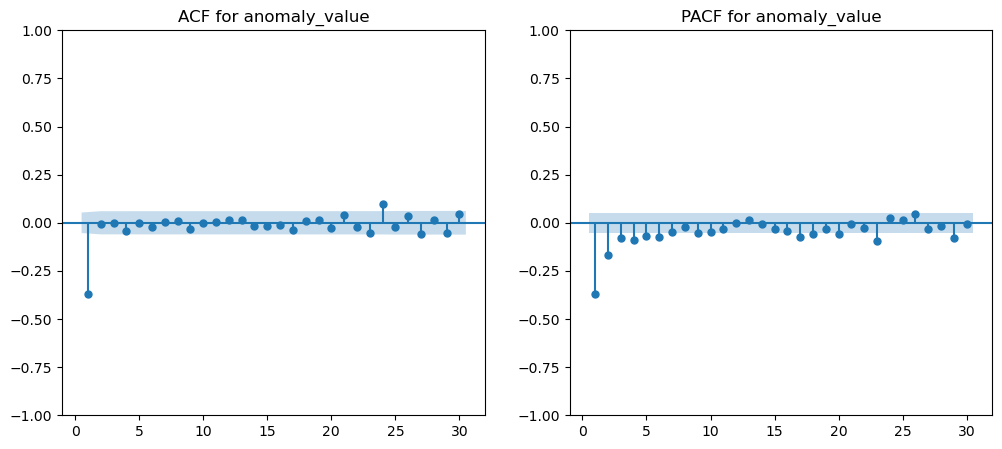

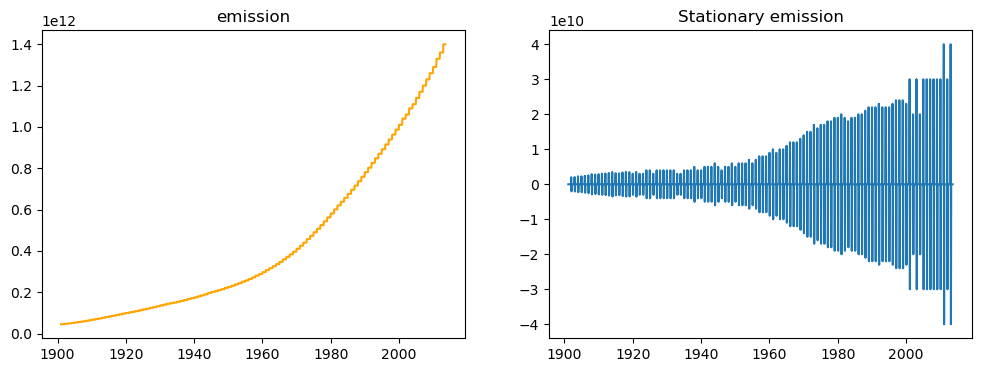

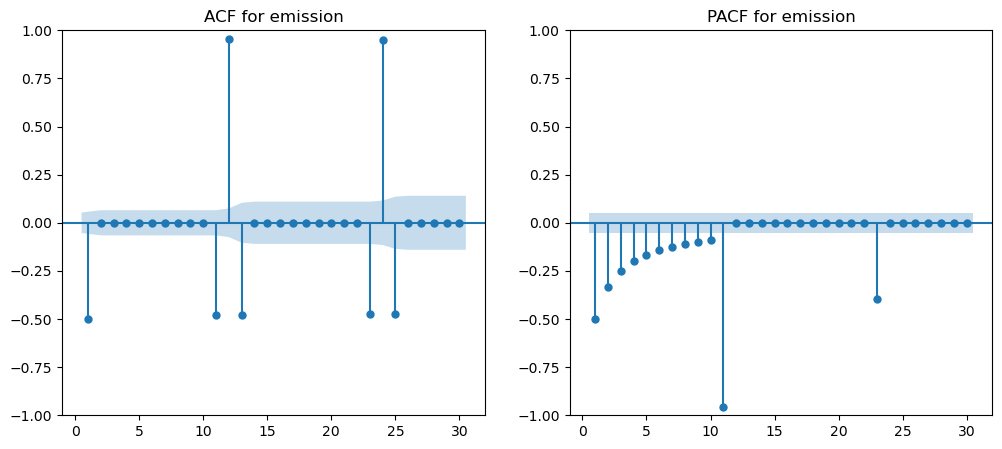

In [28]:
# plot ACF and PACF to define time windows
def plot_ACF_PACF(feature, lag = 12):
    fig, ax = plt.subplots(1,2, figsize = (12,4))
    ax[0].plot(final_df.index, final_df[feature].values, label = feature, color = 'orange')
    ax[0].set_title(f'{feature}')
    ax[1].plot(stationary_data.index, stationary_data[feature].values, label = f'stationary {feature}')
    ax[1].set_title(f'Stationary {feature}')

    fig,axs = plt.subplots(1,2, figsize = (12,5))
    plot_acf(stationary_data[feature], lags= lag,zero=False, ax=axs[0])
    axs[0].set_title(f'ACF for {feature}')
    plot_pacf(stationary_data[feature], lags= lag,zero=False, method='ywm', ax=axs[1])
    axs[1].set_title(f'PACF for {feature}')
    plt.show()


for feature in stationary_data.columns:
    plot_ACF_PACF(feature,30)




### ***4-2 Final decision on feature engineering***
After analyzing the ACF and PACF plots for each feature and the target variable, it has been determined that different features have different optimal lag lengths for the sliding window.

For example, for the feature "emission" a sliding window of 12 months is appropriate, as it showed a strong correlation at every 12th lag in PACF, and strong correlation in lage 1, 11, and 12 in ACF.

For the feature "year," a sliding window of 12 is recommended to capture variation in the data. 

For the feature "global_avg_temp," a sliding window of 5 months is suggested, as the PACF showed significant correlations up to lag 5.

For the feature "upper_95_ci" and the target variable "anomaly value," which have weak correlations beyond 2 lags, a sliding window of 2 months is recommended.

As a result, choosing the sliding window for each feature based on the observed significant lags in the ACF and PACF plots to capture the relevant information while avoiding unnecessary computational overhead can be utilized

However, using a sliding window of 12 lags for all features is also recommended for the sake of simplicity and consistency. While this may result in some non-informative lags for certain features, it will allow for easier comparison and interpretation of the results across all features. Additionally, a sliding window of 12 lags may still capture some relevant lagged values for features that showed weaker correlations beyond this lag length.

# ***5- Write necessary functions for Data Preparation***

In this section, we have developed a comprehensive set of functions that are critical for the data preparation and analysis phases of the project. These functions have been designed to ensure that the data is properly scaled, transformed, and formatted in a way that can be used by various models for training and evaluation purposes.

The first function is a scaling function that can be applied to the data using various methods, such as Min-Max scaling or Standard scaling. The second function is designed to reverse the scaling operation for a given series using the same scaler that was used to scale it. The third function focuses on reversing the stationary transformation applied to the data during the feature engineering phase.

The fourth function splits the original dataset into training, validation, and testing sets, while also separating the features and target variable. This is a crucial step in the data preparation process, as it ensures that the models are trained and evaluated on independent datasets.

The fifth function is aimed at implementing the results of the feature engineering section. It creates sliding windows for each feature, captures the lagged values, and prepares the target variable in a way that features can predict the target variable for the given time period ahead. This function is essential for ensuring that the data is properly prepared for modeling.

Finally, the last function is designed to prepare the features for feeding into the LSTM model. The function processes the data to ensure it meets the requirements for LSTM input, such as reshaping the data into three dimensions. This function is crucial for ensuring that the LSTM model can effectively learn from the data and make accurate predictions.

Overall, these functions provide a strong foundation for the data preparation and analysis phases of the project, enabling us to effectively utilize various models for training and evaluation purposes.

In [29]:
# Split data to train, validation, and test function
def split_data(df, test_val_size):

    X_train, X_val_test, y_train, y_val_test = train_test_split(df, df[target],
                                                            test_size= test_val_size*2,
                                                             shuffle=False,
                                                              random_state= 42 )

    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test,
                                                            test_size= 0.5,
                                                             shuffle=False,
                                                              random_state= 42 )
    
    shapes = [[X_train.shape,y_train.shape],[X_val.shape,y_val.shape],[X_test.shape,y_test.shape]]
    shape =pd.DataFrame(shapes, columns=['X', 'y'], index=['Train', 'Validation', 'Test'])
    display(shape)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [30]:
# Create sliding window and prediction distance function 
def sliding_window_from_df(df, targetcol_series, TIME_WINDOW, FORECAST_DISTANCE):
    X_df = pd.concat([df.shift(i) for i in range(1,TIME_WINDOW+1)], axis=1).dropna().drop(df.tail(FORECAST_DISTANCE-1).index)
    X_df.columns = pd.MultiIndex.from_product([range(1,TIME_WINDOW+1), df.columns])
    X_df.rename_axis(["lag", "variable"], axis=1, inplace=True)
    X_df.sort_index(axis=1,ascending=False, inplace=True)

    y_series = targetcol_series.shift( -FORECAST_DISTANCE + 1 ).dropna().drop(df.head(TIME_WINDOW).index)
    return X_df, y_series

In [31]:
# Prepare data for LSTM
def rolled_X_for_LSTM(X_df, TIME_WINDOW):
    X_rolled = X_df.reshape(X_df.shape[0], TIME_WINDOW, -1)
    return X_rolled

# ***6- Model Selection and Hyperparameter Tuning*** 

In this section, we focus on selecting appropriate models for predicting the target variable, "anomaly_value," and fine-tuning their respective hyperparameters for optimal performance. The models used in this study are categorized into three categories based on their characteristics and suitability for the task.

The first category comprises baseline models, namely Lasso and Huber Regressor. Lasso regression is selected to handle feature sets with potentially uninformative lagged values, as it can effectively ignore these non-informative features by assigning them zero coefficients. Additionally, considering the absence of outlier detection in our multivariate time series, Huber Regressor is chosen as it is more robust to outliers and can provide reliable predictions.

The second category includes Support Vector Regression (SVR) and Random Forest Regressor, two powerful machine learning algorithms. SVR is capable of handling multivariate time series prediction without the need for stationary transformation, thanks to its kernel functions. It is also suitable for scenarios where robustness to outliers is required. On the other hand, Random Forest Regressor, a robust ensemble-based model, By leveraging the ensemble nature of Random Forest Regressor, the model can provide more reliable predictions despite the presence of outliers. However it requires stationary transformation to be applied to the data before being used for multivariate time series prediction.

Lastly, the third category features LSTM, an end-to-end model known for its ability to capture temporal dependencies in time series data. However, before feeding the data to LSTM, a specific data preparation step is required to reshape the data into the appropriate format for LSTM input.

This section aims to carefully select models that suit the characteristics of the dataset and perform hyperparameter tuning to optimize their performance for the multivariate time series prediction task.

### ***6-1 Data Preparation***

In this section, the necessary parameters are defined for data preparation. The test and validation sizes are set at 15% of the total data to ensure sufficient data for tuning and evaluation. While this may reduce the training data size, it provides the benefits of more regularization.

The time window is set at 12 months based on the results of the feature engineering section. The forecasting distance is set to 3 as instructed.

The non-stationary and stationary datasets are split into train, validation, and test sets to accommodate models that work better with either one. The sliding window function is applied to both sets of splits, and the LSTM data preparation function is applied to the output of the sliding window function for non-stationary data.

In [32]:
# Set parameters nedded for data preparation
test_valid_size = 0.15
time_window = 12
forcast_distance = 3 
target = 'anomaly_value'

In [33]:
# split non-stationary data set
print('Splits for non-stationary dataset')
X_train, X_val, X_test, y_train, y_val, y_test =  split_data(final_df, test_valid_size)

# split stationary data set
print('Splits for stationary dataset')
X_train_st, X_val_st, X_test_st, y_train_st, y_val_st, y_test_st = split_data(stationary_data,test_valid_size)

Splits for non-stationary dataset


,X,y
Train,"(946, 5)","(946,)"
Validation,"(203, 5)","(203,)"
Test,"(203, 5)","(203,)"


Splits for stationary dataset


,X,y
Train,"(945, 5)","(945,)"
Validation,"(202, 5)","(202,)"
Test,"(203, 5)","(203,)"


In [34]:
# sliding data on non_stationary data
sliding_X_train, sliding_y_train = sliding_window_from_df(X_train,y_train, time_window,forcast_distance)
sliding_X_val, sliding_y_val = sliding_window_from_df(X_val,y_val, time_window,forcast_distance)
sliding_X_test, sliding_y_test = sliding_window_from_df(X_test,y_test, time_window,forcast_distance)

shapes = [[sliding_X_train.shape,sliding_y_train.shape],
          [sliding_X_val.shape,sliding_y_val.shape],
          [sliding_X_test.shape,sliding_y_test.shape]]

print('Sliding data for non-stationary dataset')
shape =pd.DataFrame(shapes, columns=['sliding_X', 'sliding_y'], index=['Train', 'Validation', 'Test'])
shape

Sliding data for non-stationary dataset


,sliding_X,sliding_y
Train,"(932, 60)","(932,)"
Validation,"(189, 60)","(189,)"
Test,"(189, 60)","(189,)"


In [35]:
# sliding data on stationary data
sliding_X_train_st, sliding_y_train_st = sliding_window_from_df(X_train_st,y_train_st, time_window,forcast_distance)
sliding_X_val_st, sliding_y_val_st = sliding_window_from_df(X_val_st,y_val_st, time_window,forcast_distance)
sliding_X_test_st, sliding_y_test_st = sliding_window_from_df(X_test_st,y_test_st, time_window,forcast_distance)

shapes = [[sliding_X_train_st.shape,sliding_y_train_st.shape],
          [sliding_X_val_st.shape,sliding_y_val_st.shape],
          [sliding_X_test_st.shape,sliding_y_test_st.shape]]

print('Sliding data for stationary dataset')
shape =pd.DataFrame(shapes, columns=['sliding_X_st', 'sliding_y_st'], index=['Train', 'Validation', 'Test'])
shape

Sliding data for stationary dataset


,sliding_X_st,sliding_y_st
Train,"(931, 60)","(931,)"
Validation,"(188, 60)","(188,)"
Test,"(189, 60)","(189,)"


### ***6-2 Hyperparameter Tuning, Running Model, and Visalization functions***

In this section, a set of functions is developed to facilitate the hyperparameter tuning, model fitting, and result visualization for multiple machine learning algorithms (Lasso, Huber Regressor, SVR (Support Vector Regression), and Random Forest Regressor) applied to multivariate time series data.

**The first function**, "tuner," takes a list of scalers, the model to be tuned, the parameters to be optimized, the number of iterations for parameter search, and the tuning datasets. It returns the best parameters based on the mean absolute error and the coefficient of determination for each scaling method. The training and validation datasets are combined to create dedicated tuning datasets, allowing fair evaluation of the tuned models.

Regarding scaling methods, considering the distribution characteristics of the features and the potential presence of outliers, it is important to evaluate different scaling methods for the dataset. MinMaxScaler preserves the original distribution shape and is suitable when maintaining relative relationships between data points is crucial. StandardScaler, on the other hand, is beneficial for transforming skewed features towards normality.

Given the possibility of outliers in the dataset and the absence of specific outlier handling, it is recommended to explore the performance of RobustScaler(with_centering=True). This method, which uses the median and interquartile range (IQR) for scaling, is more robust to outliers and can handle skewed features effectively.

Additionally, RobustScaler(with_centering=False) can be considered as it also utilizes the IQR for scaling without subtracting the median. While it may not be as robust as RobustScaler(with_centering=True) in handling outliers, it offers improved resilience compared to MinMaxScaler and StandardScaler, making it suitable for skewed data.

Throughout the tuning process, mean absolute error and coefficient of determination are considered as key metrics. The mean absolute error provides an average measure of the differences between predicted and actual values, giving insights into the model's accuracy. The coefficient of determination indicates the proportion of the dependent variable's variance that can be explained by the independent variables, offering a measure of the model's overall predictive power.

**The second function**, "run_model," accepts the tuned model, the best scaler determined by the tuning process, the optimized parameters, and the training and test datasets. It calculates and returns the mean absolute error, mean squared error, mean absolute percentage error ,and coefficient of determination for the tuned model on the test dataset for evaluation purposes

It is worth mentioning that Due to the target variable is small, in addition to MAE, MSE, and R_squared comparing models using MAPE can be more informative. MAPE considers relative percentage differences, allowing fair comparison regardless of the target variable's scale. It provides insights into the models' relative accuracy and impact on predictions.

These functions collectively enable a systematic approach to optimize hyperparameters, fit the tuned models, and evaluate their performance on multivariate time series data. By leveraging appropriate scaling methods and considering relevant evaluation metrics,

In [36]:
# Show statistical charecteristics of final dataframe
final_df.describe()

,upper_95_ci,global_avg_temp,year,emission,anomaly_value
count,1352.000000,1352.000000,1352.000000,1.352000e+03,1352.000000
mean,-0.077768,0.046901,1956.834320,4.305429e+11,-0.027911
std,0.306185,0.325740,32.536524,3.763298e+11,0.294270
min,-0.910000,-0.790000,1901.000000,4.482107e+10,-0.832000
25%,-0.295000,-0.190000,1929.000000,1.320000e+11,-0.232250
50%,-0.091500,-0.010000,1957.000000,2.720000e+11,-0.048000
75%,0.112250,0.270000,1985.000000,6.760000e+11,0.144000
max,0.785000,0.960000,2013.000000,1.400000e+12,0.828000


In [37]:
# Check skewness of columns in the final Dataframe
final_df.skew()

upper_95_ci        0.160642
global_avg_temp    0.414362
year               0.000181
emission           0.977207
anomaly_value      0.239019
dtype: float64

In [38]:
# List of scalers
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(with_centering=True), 
           RobustScaler(with_centering=False)]

# Tunning set for non-stationary data
X_tuning = pd.concat([sliding_X_train, sliding_X_val])
y_tuning = pd.concat([sliding_y_train, sliding_y_val])

# Tunning set for stationary data
X_tuning_st = pd.concat([sliding_X_train_st, sliding_X_val_st])
y_tuning_st = pd.concat([sliding_y_train_st, sliding_y_val_st])

print(X_tuning.shape, y_tuning.shape)
print(X_tuning_st.shape, y_tuning_st.shape)

(1121, 60) (1121,)
(1119, 60) (1119,)


In [39]:
# function for hyperparameter tuning
def tuner(scalers, model, params,iter, X_tune, y_tune ): 
    tscv = TimeSeriesSplit(n_splits=5)   # Using TimeSeriesSplit to insure of not shuffeling in cv argument
    results = []

    # Tune the parameters of model for each scaling method
    for scaler in scalers:
        
        tuning_pipe = Pipeline([('scaler',scaler), ('model',model)])

        wrapped_model = TransformedTargetRegressor(regressor=tuning_pipe, transformer=scaler)

        tuner = RandomizedSearchCV(wrapped_model
                                ,param_distributions= params, cv=tscv, 
                                n_iter=iter, scoring='neg_mean_absolute_error',
                                random_state= 42)
        tuner.fit(X_tune,y_tune)

        # Create a dictionary of best parameters by key of names equals to that parameter in the model
        best_parameters = {}
        for key in tuner.best_params_:
            nkey = key[len('regressor__model__'):]
            best_parameters[nkey] = tuner.best_params_[key]

        # Set the best parameters to see R_square of the model
        tuned_model = model.set_params(**best_parameters) 
        tuned_model.fit(X_tune,y_tune)
        R_2 = tuned_model.score(X_tune,y_tune)

        results.append({'Scaler': scaler, 'Best_parameter': best_parameters, 
                    'Best_MAE_score': tuner.best_score_ ,
                    'R2': R_2})

    # Create dataframe of final results and return it
    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values(['Best_MAE_score','R2'], ascending= [False,True], ignore_index=True)
    display(result_df)
    
    return result_df


https://stackoverflow.com/questions/74258306/how-to-scale-train-and-fit-data-in-classifier-pipeline-correctly

https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/

In [70]:
# Function for running the tuned model
def run_model(model, scaler, params, X_train,X_test,X_val,y_train,y_test, stationarity = True, firs_value = first_anomaly_values):
    # Set best parameters to the model
    model = model(**params)

    # Creat a pipeline for first scale data and then fit the model
    model_pipe = Pipeline([('scaler',scaler),('model',model)])

    # Instantiate a TransformedTargetRegressor to insure scaling is done to eatures and target variabels 
    # and reverse scaling on predictions
    wrapped_model = TransformedTargetRegressor(regressor=model_pipe, transformer=scaler)

    # Fit the model on train set
    wrapped_model.fit(X_train, y_train)

    # Predict on all sets and reverse scaling
    train_prediction = wrapped_model.predict(X_train)
    val_prediction = wrapped_model.predict(X_val)
    test_prediction = wrapped_model.predict(X_test)
  
    # Reverse stationary Transformation
    if stationarity == True:
        train_prediction= np.cumsum(train_prediction) + firs_value
        val_prediction = np.cumsum(val_prediction) + sliding_y_val[-1]
        test_prediction = np.cumsum(test_prediction) + sliding_y_test[-1]

    # Calculate metrics 
    MAE = mean_absolute_error(sliding_y_test,test_prediction)
    MAPE = mean_absolute_percentage_error(sliding_y_test,test_prediction)
    MSE = mean_squared_error(sliding_y_test,test_prediction)
    R_2 = r2_score(sliding_y_test,test_prediction)


    # provide metrics in the format of dataframe
    evaluation = {'MAE':[MAE], 'MAPE': MAPE,'MSE':[MSE], 'R_2': [R_2]}
    eval_df = pd.DataFrame(evaluation, index=[f'{model} results'])
    display(eval_df)

    # Return metrics in addition to predictions of all data
    return eval_df, train_prediction, val_prediction, test_prediction

In [41]:
# Function for plotting predicted values for train, validation and test data sets 
def plot_predictions(train_predict, val_predict, test_predict, stationirity = False):
    plt.figure(figsize=(12,7))

    # Create actual series of target variable
    Actual = pd.concat([sliding_y_train, sliding_y_val, sliding_y_test])

    # Extract indexes of train, validation, and test data sets
    if stationirity == True:
        y_train_index = sliding_y_train_st.index
        y_val_index = sliding_y_val_st.index
        y_test_index = sliding_y_test_st.index
    else:
        y_train_index = sliding_y_train.index
        y_val_index = sliding_y_val.index
        y_test_index = sliding_y_test.index

    # plot Actual anomaly value
    plt.plot(Actual, label = 'Anomaly value') 

    # plot predicted values for train, validation and test data sets 
    plt.plot(y_train_index, train_predict, label = 'prediction on train set')
    plt.plot(y_val_index, val_predict, label = 'prediction on validation set')
    plt.plot(y_test_index,test_predict, label = 'prediction on test set')
    
    plt.xlabel('Time')
    plt.ylabel('Anomaly_value')
    plt.legend()
    
    plt.show()

In [42]:
# Function to Plot residuals for train, validation, and test data sets
def residual_plot(train_predict, val_predict, test_predict, stationarity = False):
    
    # Make prediction series for all of sets 
    predictions = np.concatenate([train_predict.reshape(-1,1), 
                                    val_predict.reshape(-1,1), 
                                    test_predict.reshape(-1,1)])
    
    # Create actual series of target variable
    Actual = pd.concat([sliding_y_train, sliding_y_val, sliding_y_test]).values

    # Creat y_train, y_validation, y_test and the indexes for stationary and non stationary data
    if stationarity == True:
        y_train = sliding_y_train.values[1:]
        y_val = sliding_y_val.values[1:]
        y_test = sliding_y_test.values

        train_index = sliding_y_train_st.index
        val_index = sliding_y_val_st.index
        test_index = sliding_y_test_st.index
        Actual = Actual[2:]
        
    else:
        y_train = sliding_y_train.values
        y_val = sliding_y_val.values
        y_test = sliding_y_test.values

        train_index = sliding_y_train.index
        val_index = sliding_y_val.index
        test_index = sliding_y_test.index

    data_min = np.min(Actual)
    data_max = np.max(Actual)

    # Calculate residuals for train, validation, and test sets
    train_residuals = (y_train - train_predict).reshape(-1,1)
    val_residuals = (y_val - val_predict).reshape(-1,1)
    test_residuals = (y_test - test_predict).reshape(-1,1)

    fig, axs = plt.subplots(2,1, figsize = (10,10))

    # Plot actual target variable VS predictions
    axs[0].scatter(Actual,predictions)
    
    axs[0].set_xlabel('Actual')
    axs[0].set_ylabel('Prediction')
    axs[0].set_title('Anomaly Value')
    axs[0].set_xlim(data_min, data_max)
    axs[0].set_ylim(data_min, data_max)
     
    # plot residuals over time
    axs[1].scatter(train_index, train_residuals)
    axs[1].scatter(val_index, val_residuals)
    axs[1].scatter(test_index, test_residuals)
    axs[1].axhline(0, color = 'red')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Residuals')
    axs[1].set_title('Residuals over time')

    fig.tight_layout()
    plt.show()

### ***6-2 Lasso***

To determine the optimal values for the alpha parameter in Lasso regularization, a range of values is considered. In this case, five values are selected, ranging from 0.01 times the default value to 100 times the default value. The chosen values for alpha are [0.01, 0.1, 1, 10, 100].

The alpha parameter controls the level of regularization in Lasso regression. A higher alpha value corresponds to stronger regularization, effectively shrinking the coefficients towards zero.

After tuning and running the model on the dataset, an analysis of the residual plot reveals distinct characteristics in the prediction performance across different subsets. Specifically, while the predictions on the training dataset demonstrate a relatively balanced distribution of errors, the model tends to overestimate the actual targets in the validation dataset. Moreover, on the test dataset, the trained model exhibits a tendency to underestimate the true targets.

In [43]:
# Set lasso parameters
lasso_params = {"regressor__model__alpha" : [0.01, 0.1, 1, 10, 100]}

# Tune Lasso
lasso_tuned = tuner(scalers, Lasso(max_iter=100000),lasso_params, 5, X_tuning, y_tuning )

,Scaler,Best_parameter,Best_MAE_score,R2
0,StandardScaler(),{'alpha': 0.1},-0.100787,0.546929
1,RobustScaler(),{'alpha': 0.01},-0.100966,0.638651
2,RobustScaler(with_centering=False),{'alpha': 0.01},-0.100966,0.638651
3,MinMaxScaler(),{'alpha': 0.01},-0.131578,0.638651


The second result is chosen as it has aproximatly the same MAE but better R2

In [44]:
# Run Lasso model on the second best hyper-parameter
lasso_result, lasso_train_pr, lasso_val_pr, lasso_test_pr = run_model(Lasso,lasso_tuned.loc[1,'Scaler'], 
                                                                      lasso_tuned.loc[1,'Best_parameter'],
                                                                    sliding_X_train,sliding_X_val,sliding_X_test, 
                                                                    sliding_y_train,sliding_y_test, stationarity=False)
    

,MAE,MAPE,MSE,R_2
Lasso(alpha=0.01) results,0.307105,0.642594,0.115238,-7.02927


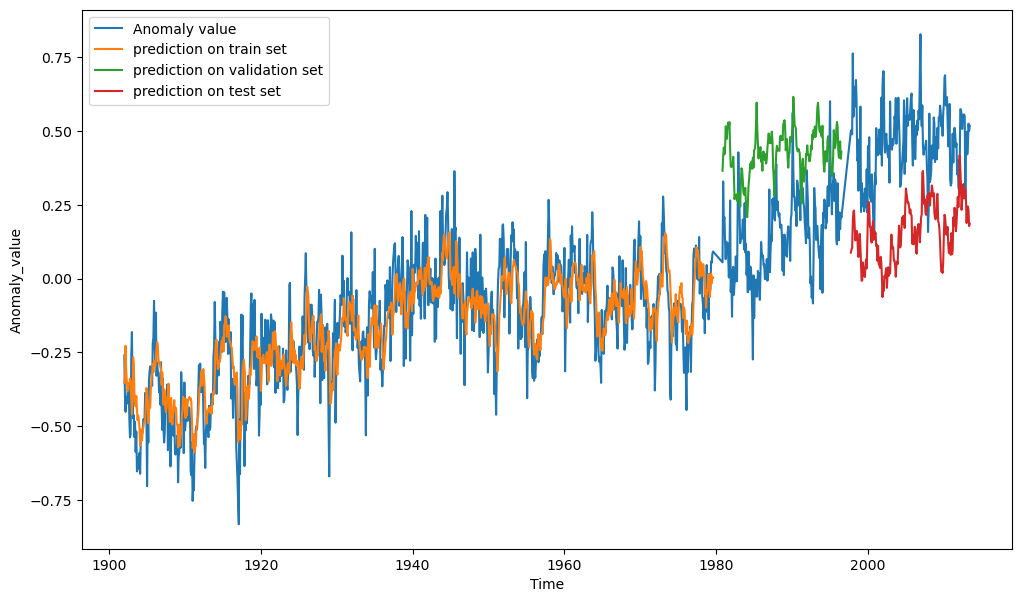

In [45]:
plot_predictions(lasso_train_pr, lasso_val_pr, lasso_test_pr)

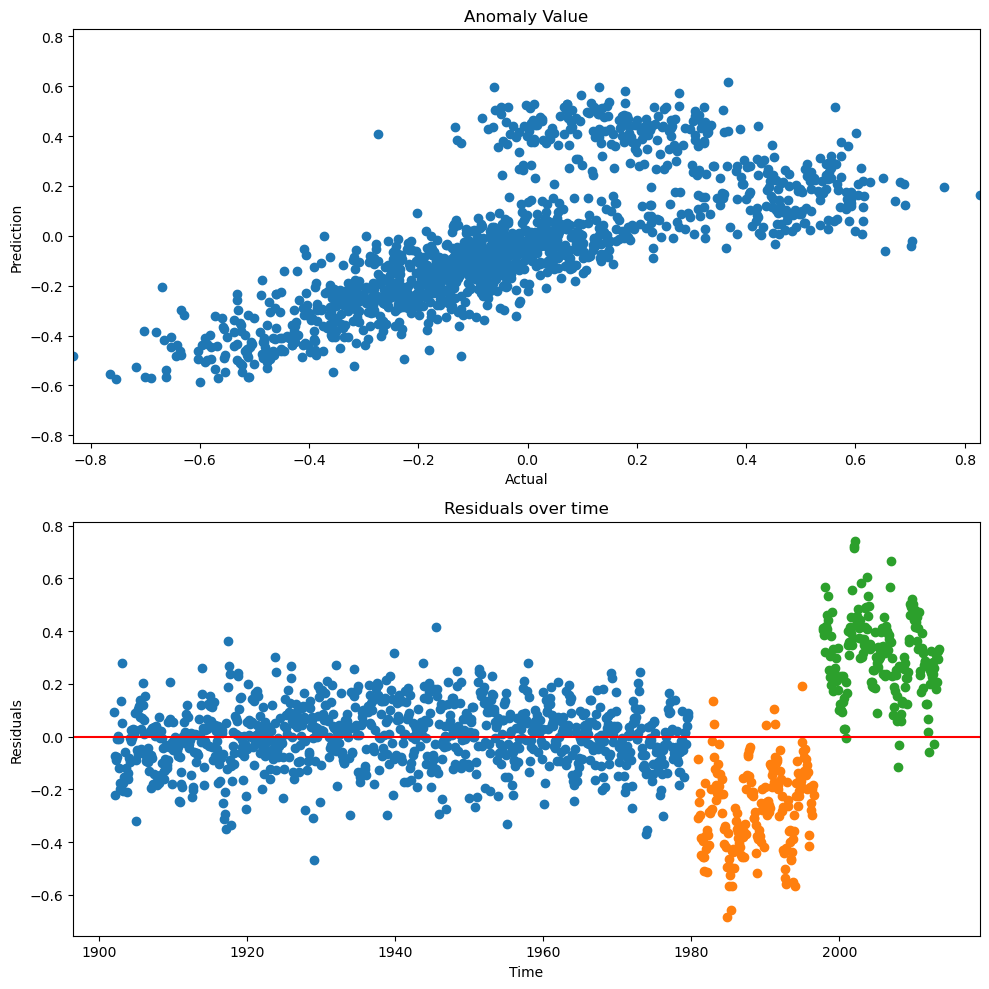

In [46]:
residual_plot(lasso_train_pr, lasso_val_pr, lasso_test_pr)

### ***6-3 Huber regressor***

The HuberRegressor has two important parameters: alpha and epsilon.

The alpha parameter controls the degree of regularization in the model. A higher value of alpha leads to stronger regularization, resulting in a simpler model with potentially lower variance but higher bias. On the other hand, a lower alpha value reduces regularization, allowing the model to fit the training data more closely but potentially leading to overfitting.

The epsilon defines the region where the loss function is less sensitive to outliers. Larger values of epsilon make the model more robust to outliers, while smaller values make it more sensitive to them.

Tuning these parameters requires striking a balance between model complexity, robustness to outliers, and generalization ability.

After tuning and running the model on the dataset, the model demonstrates a relatively balanced distribution of errors. However, as the analysis progresses from the validation to the test datasets, a consistent pattern emerges: the model consistently underestimates the actual targets. This observation suggests a systematic bias in the model's predictions, particularly becoming more pronounced as the prediction horizon extends further into the future.

In [47]:
# Set Huber regressor's hyper-parameters
params = {'regressor__model__alpha': [0.01, 0.1, 1, 10, 100], 'regressor__model__epsilon': [1, 1.2,1.5,2, 2.5]}

# Tune the model
huber_tunned= tuner(scalers = scalers, model=HuberRegressor(max_iter=100000), params=params,
                     X_tune=X_tuning, y_tune=y_tuning, iter=25)


,Scaler,Best_parameter,Best_MAE_score,R2
0,StandardScaler(),"{'epsilon': 1, 'alpha': 1}",-0.104330,-0.230186
1,RobustScaler(),"{'epsilon': 1.2, 'alpha': 1}",-0.104596,-0.230186
2,MinMaxScaler(),"{'epsilon': 1, 'alpha': 1}",-0.106254,-0.230186
3,RobustScaler(with_centering=False),"{'epsilon': 1, 'alpha': 10}",-0.112467,-0.230186


In [48]:
# Run Huber regressor on best parameters
huber_result, hube_train_pr, huber_val_pr, huber_test_pr = run_model(model= HuberRegressor,
                                                                      scaler= huber_tunned.loc[0,'Scaler'],
                                                                      params= huber_tunned.loc[0,'Best_parameter'],
                                                                      X_train=sliding_X_train, X_val= sliding_X_val,
                                                                      X_test= sliding_X_test, y_train= sliding_y_train,
                                                                      y_test = sliding_y_test, stationarity=False)

,MAE,MAPE,MSE,R_2
"HuberRegressor(alpha=1, epsilon=1) results",0.432654,0.942779,0.202816,-13.13137


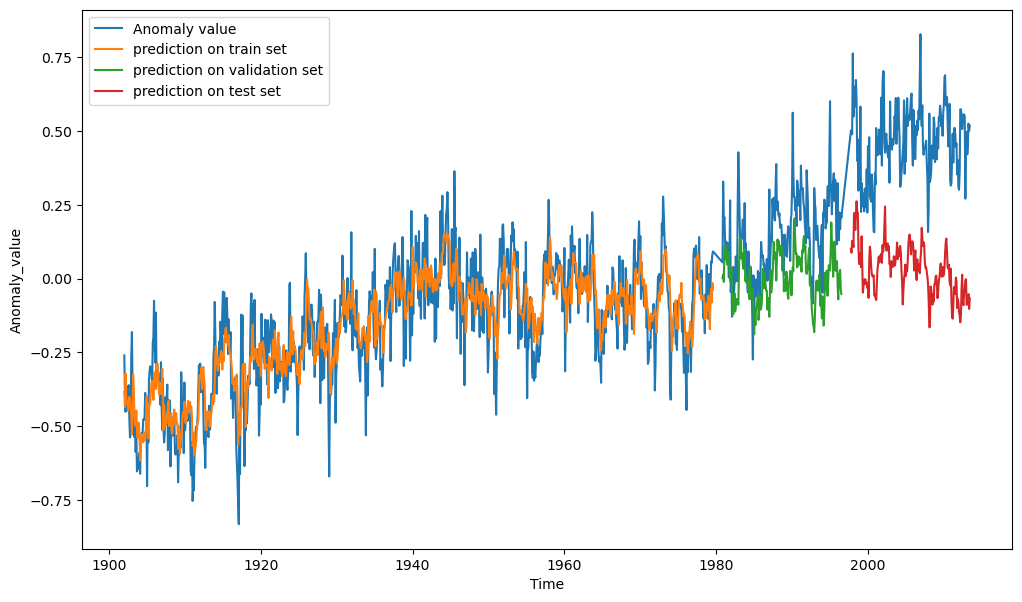

In [49]:
plot_predictions(hube_train_pr, huber_val_pr, huber_test_pr)

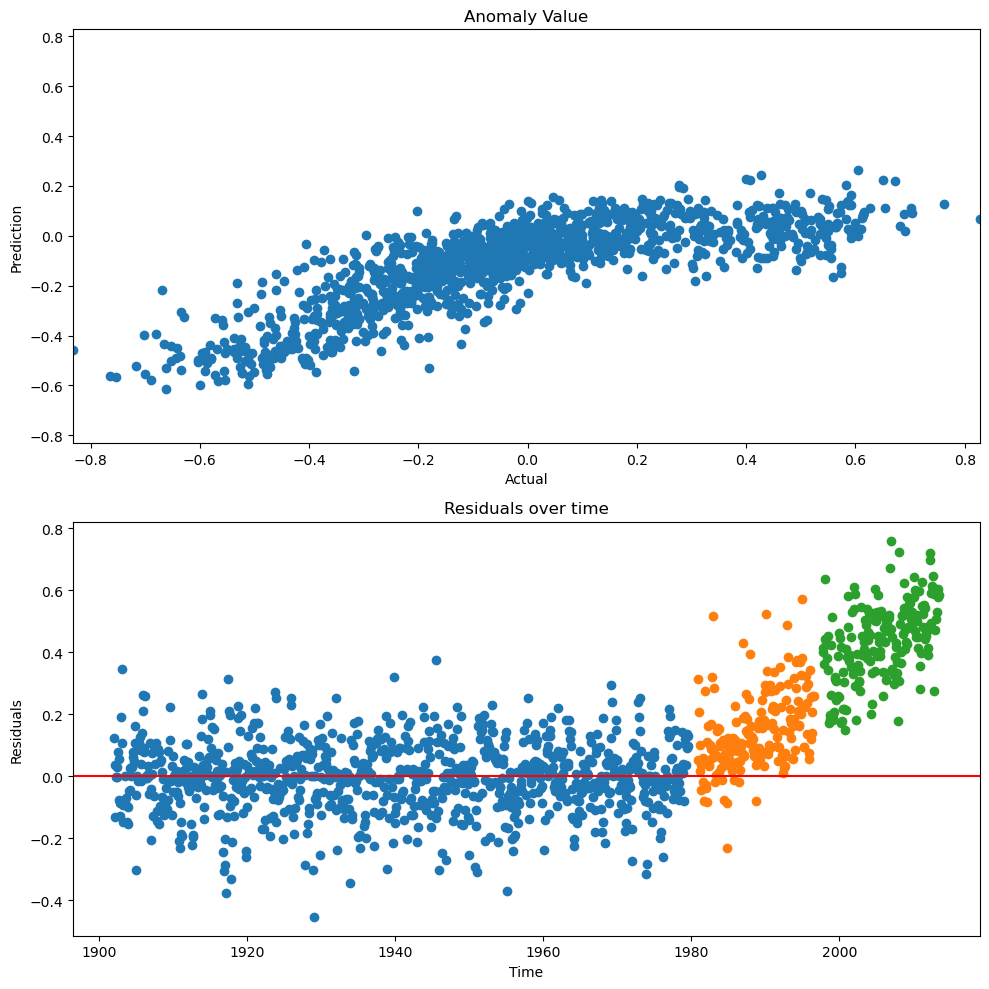

In [50]:
residual_plot(hube_train_pr, huber_val_pr, huber_test_pr)

### ***6-4 SVR***

SVR (Support Vector Regression) has several important parameters that influence its performance:

Epsilon (epsilon): It determines the margin of error allowed in SVR predictions. Larger values provide more tolerance for errors, while smaller values make the model stricter.

Kernel (kernel): It defines the similarity measure between data points. Different kernels capture different patterns in the data.

C (C): It balances the trade-off between training error and model complexity. Smaller values result in simpler models with potentially higher bias, while larger values lead to more complex models with potentially higher variance.


After tuning and running the SVR model, similar to Huber regression, a consistent pattern emerges in its performance. The model demonstrates a balanced distribution of errors initially, but consistently underestimates the actual targets as the analysis progresses from validation to test datasets. This indicates a systematic bias that becomes more pronounced with longer prediction horizons.

In [51]:
# Set SVR hyper parameters
params = {
            'regressor__model__kernel' : ['linear', 'rbf'],
            'regressor__model__C' : [50, 100, 200, 500],
            'regressor__model__epsilon' : [0.01, 0.1, 10, 20],           
            }

# Tune the model
svr_tunned = tuner(scalers = scalers, model = SVR(max_iter=100000), 
                    params=params, X_tune=X_tuning, 
                    y_tune=y_tuning, iter=24)

,Scaler,Best_parameter,Best_MAE_score,R2
0,RobustScaler(with_centering=False),"{'kernel': 'rbf', 'epsilon': 0.1, 'C': 500}",-0.115636,6.528569e-01
1,MinMaxScaler(),"{'kernel': 'linear', 'epsilon': 0.1, 'C': 50}",-0.132392,-5.166483e+42
2,StandardScaler(),"{'kernel': 'linear', 'epsilon': 0.01, 'C': 50}",-0.209652,-8.075047e+41
3,RobustScaler(),"{'kernel': 'rbf', 'epsilon': 0.1, 'C': 50}",-0.223198,6.464203e-01


In [73]:
# Run SVR on best parameters
svr_result, svr_train_pr, svr_val_pr, svr_test_pr = run_model(model= SVR,
                                                                      scaler= svr_tunned.loc[0,'Scaler'],
                                                                      params= svr_tunned.loc[0,'Best_parameter'],
                                                                      X_train=sliding_X_train, X_val= sliding_X_val,
                                                                      X_test= sliding_X_test, y_train= sliding_y_train,
                                                                      y_test = sliding_y_test, stationarity=False)

,MAE,MAPE,MSE,R_2
SVR(C=500) results,0.550228,1.216808,0.320048,-21.299616


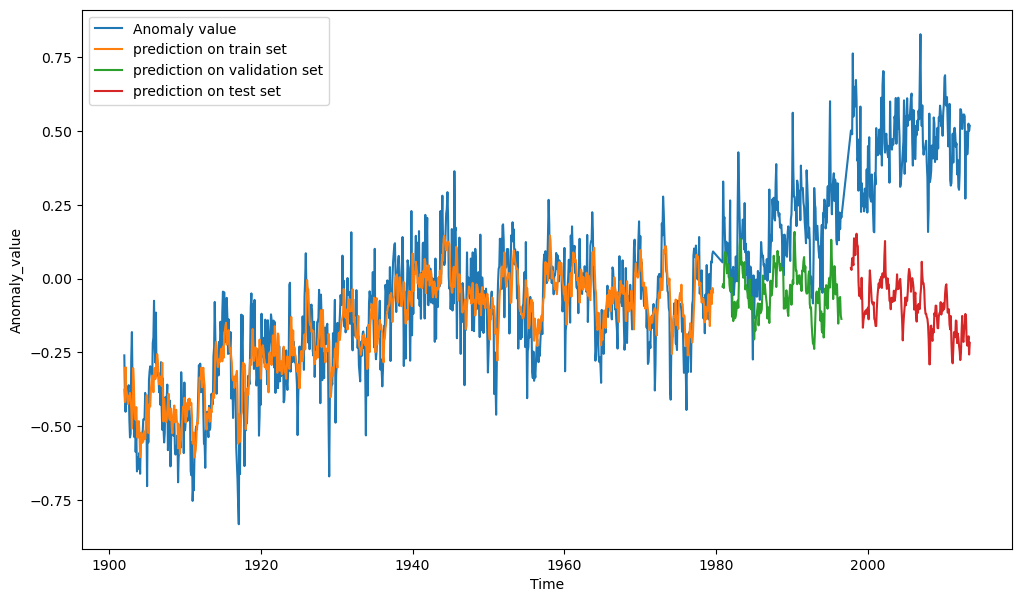

In [74]:
plot_predictions(svr_train_pr, svr_val_pr, svr_test_pr)

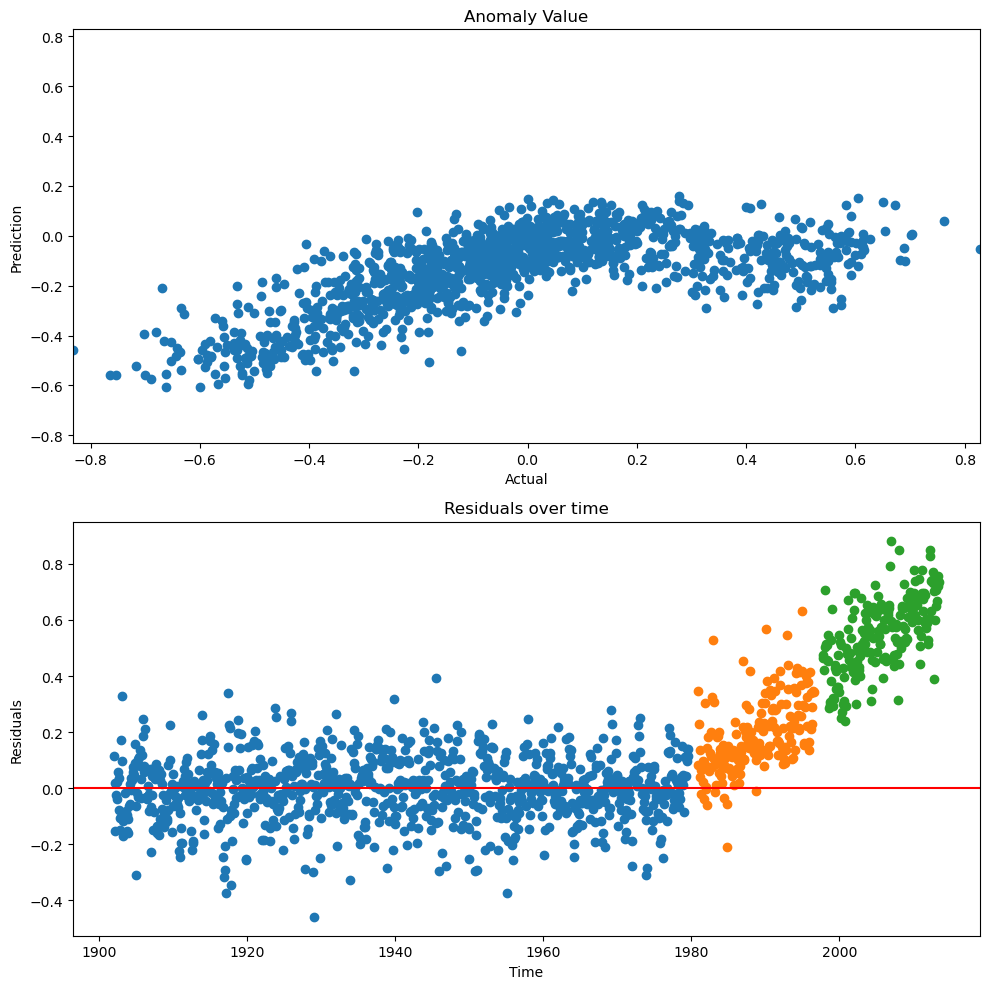

In [55]:
residual_plot(svr_train_pr, svr_val_pr, svr_test_pr)

### ***6-5 Random forest on stationary data***

After tuning and running the RandomForestRegressor model, it becomes evident that the model tends to consistently overestimate the predictions across all datasets, including the train, validation, and test sets. Notably, this overestimation is more pronounced in the validation and test datasets compared to the training dataset. 

In [56]:
# Define hyper-parameters
n_estimators = [int(x) for x in np.linspace(start = 200,stop = 1000, num = 5)] # define 5 values for n_stimator
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 10, stop = 100, num = 4)] # define 4 values for max_depth
max_depth.append(None) # to include the default value of sklearn for this hyperprameter. So max_depth have 5 values
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

# Set hyper-parameters
params = {
    'regressor__model__n_estimators': n_estimators,
    'regressor__model__max_features': max_features,
    'regressor__model__max_depth': max_depth,
    'regressor__model__min_samples_split': min_samples_split,
    'regressor__model__min_samples_leaf': min_samples_leaf,
    'regressor__model__bootstrap' : bootstrap    
}

# Tune the model on stationary tuning data set
rf_tunned = tuner(scalers = scalers, model = RandomForestRegressor(), 
                    params=params, X_tune=X_tuning_st, 
                    y_tune=y_tuning_st, iter=20)

,Scaler,Best_parameter,Best_MAE_score,R2
0,StandardScaler(),"{'n_estimators': 1000, 'min_samples_split': 5,...",-0.087695,0.368790
1,MinMaxScaler(),"{'n_estimators': 1000, 'min_samples_split': 5,...",-0.087696,0.367240
2,RobustScaler(),"{'n_estimators': 1000, 'min_samples_split': 5,...",-0.087713,0.372438
3,RobustScaler(with_centering=False),"{'n_estimators': 1000, 'min_samples_split': 5,...",-0.087803,0.368119


In [57]:
rf_result, rf_train_pr, rf_val_pr, rf_test_pr = run_model(model= RandomForestRegressor,
                                                                      scaler= rf_tunned.loc[0,'Scaler'],
                                                                      params= rf_tunned.loc[0,'Best_parameter'],
                                                                      X_train=sliding_X_train_st, X_val= sliding_X_val_st,
                                                                      X_test= sliding_X_test_st, y_train= sliding_y_train_st,
                                                                      y_test = sliding_y_test_st, stationarity=True)

,MAE,MAPE,MSE,R_2
"RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=4,\n min_samples_split=5, n_estimators=1000) results",0.131332,0.367081,0.02565,-0.787158


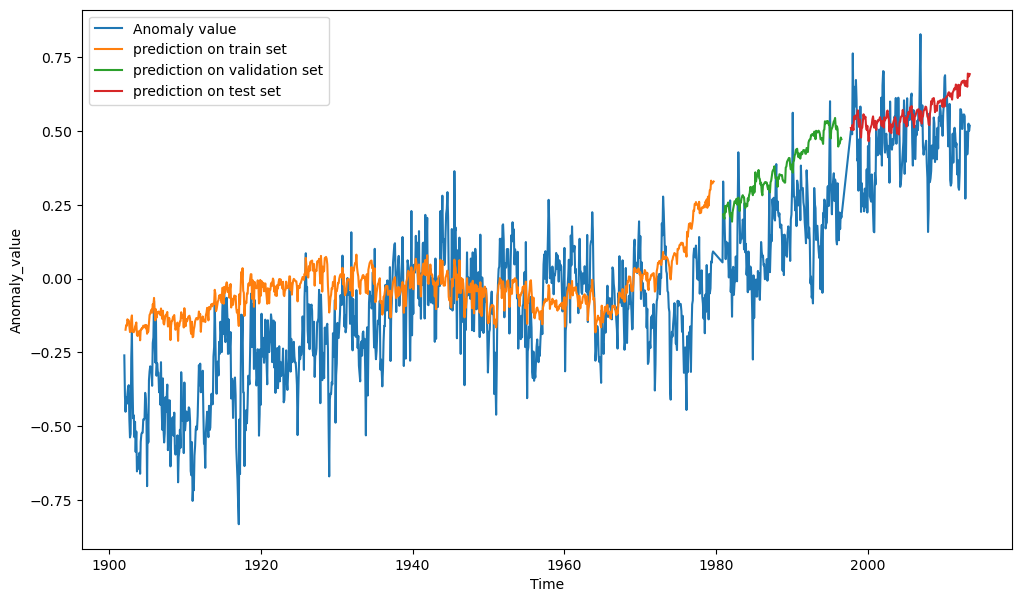

In [58]:
plot_predictions(rf_train_pr, rf_val_pr, rf_test_pr, stationirity=True)

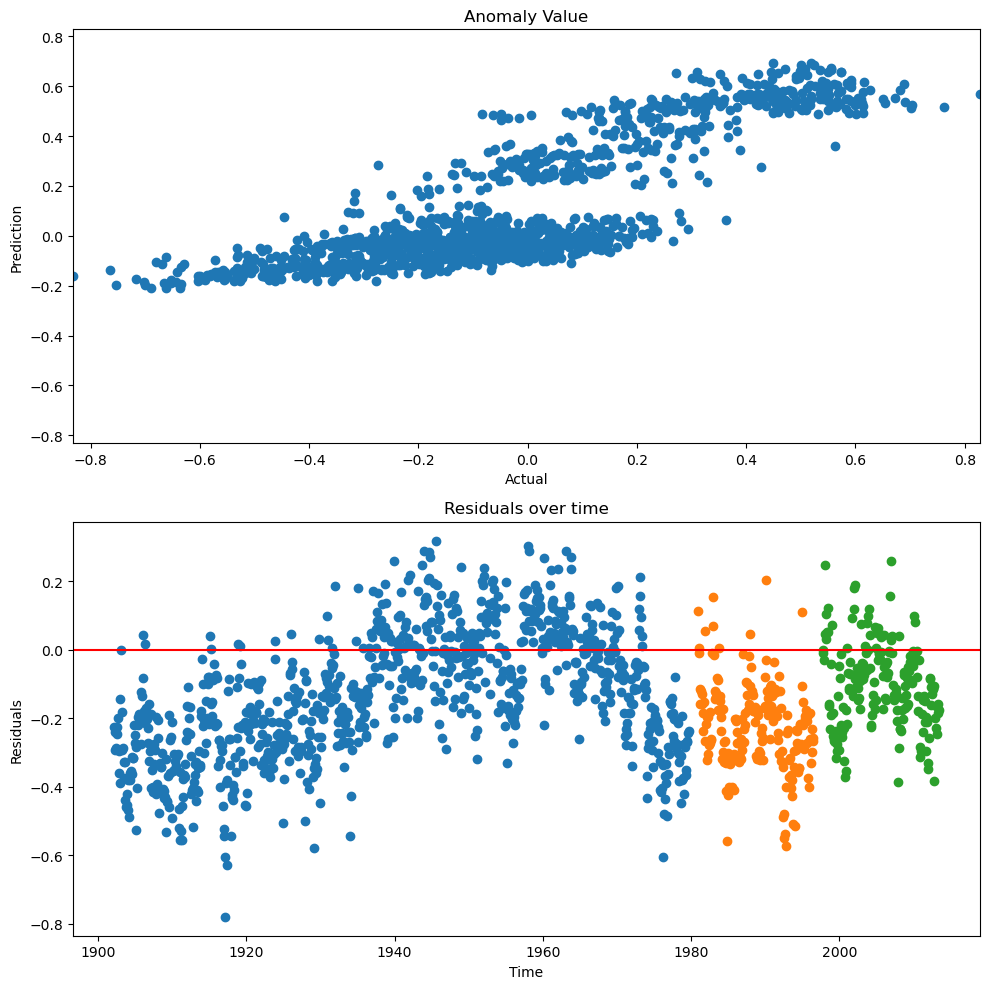

In [59]:
residual_plot(rf_train_pr, rf_val_pr, rf_test_pr, stationarity=True)

### ***6-5 LSTM***

To implement LSTM on our multivariate time series data, several functions have been developed:

1- lstm_scaler: This function takes a scaling method, along with the train, validation, and test datasets, as inputs. It prepares the data by scaling it and reshaping it in a format suitable for LSTM.

2- lstm_creator: This function creates the LSTM model with a specified number of layers, dropout rate for regularization, optimizer for compilation, and input shape of the data.

3- lstm_tuner: This function is used for tuning the LSTM. It takes the train and validation datasets, along with a dictionary of hyperparameters to be tuned, and the number of iterations to check all possible combinations. It returns the best parameters, best model, and the best results based on the defined tuning criteria. MAE is used as the metric for tuning the LSTM, similar to other machine learning algorithms in the study. Early stopping is implemented to stop training based on a specified patience and restore the best weights. Additionally, a checkpoint is defined to save the best model.

4- plot_train_val: This function is used to plot the loss and the defined metric (e.g., MAE) for both the validation and train datasets during the training process.

5- run_model: This function combines all the previous functions together. It applies them for each scaling method and selects the best model, referred to as final_model. It plots the loss and metrics for the train and validation datasets using the plot_train_val function. It displays the summary of the model, the best hyperparameters of the final model, evaluates the final model on the scaled test dataset, and provides evaluation metrics such as MAE, MAPE, MSE, and coefficient of determination to evaluates the LSTM on the unscaled test dataset.


Two sets of parameters are defined for implementing LSTM.

The first set consists of parameters that do not require tuning, such as learning_rate, lstm_cell_size, epochs, and patience. These parameters can be manually adjusted based on specific requirements. Notably, if the final tuned model has two layers, the number of LSTM cells in the second layer would be half of the cells in the first layer. Additionally, if the optimizer is SGD or Adagrad, the learning rate would be set as 10 times the specified learning_rate.

The second set includes layer, dropouts, optimizer, and batch_size, which are considered as parameters to be tuned during LSTM implementation. These parameters can significantly impact the model's performance and are subject to optimization to achieve the best results.

By defining these parameter sets, the implementation of LSTM becomes more flexible and allows for both manual adjustment and automatic tuning, enabling customization and optimization for specific requirements and data characteristics.


In [60]:
learning_rate = 0.001
lstm_cell_size = 80
epochs = 1000
patience = 20

layer = [1,2]
dropouts = [0.25, 0.3, 0.35]
optimizer = [RMSprop, Adam, SGD, Adagrad]
batch_size = [64,128]


In [61]:
def lstm_scaler(scaler, X_train, X_val, X_test, y_train, y_val, y_test):
    # Scale train set
    X_tr_sc = scaler.fit_transform(X_train)
    y_tr_sc = scaler.fit_transform(y_train.values.reshape(-1,1))

    # scale validation set
    X_val_sc = scaler.fit_transform(X_val)
    y_val_sc = scaler.fit_transform(y_val.values.reshape(-1,1))

    # scale test set
    X_ts_sc = scaler.fit_transform(X_test)
    y_ts_sc = scaler.fit_transform(y_test.values.reshape(-1,1))

    # Make data sutible for LSTM
    X_train_LSTM = rolled_X_for_LSTM(X_tr_sc, time_window)
    X_val_LSTM = rolled_X_for_LSTM(X_val_sc, time_window)
    X_test_LSTM = rolled_X_for_LSTM(X_ts_sc, time_window)

    return X_train_LSTM, X_val_LSTM, X_test_LSTM, y_tr_sc, y_val_sc, y_ts_sc

    

In [62]:
def lstm_creator(layer, dropout, optimizer, column_count):
    be.clear_session()
    tf.random.set_seed(42)

    lstm_model = Sequential()

    # LSTM Layer 1
    lstm_model.add( LSTM(lstm_cell_size, activation='relu', return_sequences=False if layer ==1 else True, 
                            input_shape=(time_window,column_count),
                        kernel_regularizer=l1(0.01), kernel_initializer='glorot_normal'
                        ))  
    lstm_model.add(Dropout(dropout))

    # LSTM layer 2
    if layer == 2:
        lstm_model.add( LSTM(lstm_cell_size//2, activation='relu', 
                                kernel_regularizer=l1(0.01), 
                                return_sequences=False) )
        lstm_model.add(Dropout(dropout))

    # the output layer:
    lstm_model.add(  Dense(1) ) 

    # Define different learning rate for different optimizers
    if optimizer == RMSprop or optimizer == Adam:
        optimizer = optimizer(learning_rate=learning_rate) 
    else:  optimizer = optimizer(learning_rate=learning_rate*10)   

    ## Complile model on loss = mean_absolute_error and metrics = mean_squared_error
    lstm_model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_squared_error'])

    return lstm_model

In [63]:
def lstm_tuner(X_train, X_val, y_train, y_val, params, iter):
    
    # Create grid of all parameters
    parameters_grid = list(itertools.product(*params.values()))

    # select randomly from the grid
    rnd_grid = sample(parameters_grid, k=iter)

    best_score = None
    for layer, dropout, optimizer, batch_size in rnd_grid:

        # number of input variables
        column_count=X_train.shape[2]
        
        # Create LSTM
        lstm_model = lstm_creator(layer,dropout, optimizer, column_count)

        # Define check point
        checkpoint_path = "best_model.hdf5"
        checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
        
        # Define early stoping
        early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=0, mode='min', restore_best_weights=True)

        # Fit the LSTM on Data
        history = lstm_model.fit(x=X_train,
                y=y_train, 
                batch_size=batch_size, 
                validation_data=(X_val,y_val), 
                epochs=epochs,
                callbacks=[checkpoint,early_stop],
                verbose=0,
                shuffle=False,
                )
        
        # Save best MAE, best history, best model, and best hyper-parameters
        if best_score == None or  checkpoint.best < best_score:  
            best_score = checkpoint.best
            best_history = history.history
            best_model = load_model('best_model.hdf5')
            best_params = {
                            'layer':layer,
                            'dropout': dropout,
                            'optimizer':optimizer,
                            'batch_size':batch_size,
                            'Best_MAE': best_score}
              
    results_df = pd.DataFrame([best_params])
    display(results_df)
    return best_params, best_history, best_model

        


In [64]:
def plot_train_val(results):
    
    # Plot the MAE of train and validation Datasets
    fig, axs = plt.subplots(1,2 , figsize = (12,6))
    axs[0].plot(results['loss'])
    axs[0].plot(results['val_loss'])
    axs[0].set_title('Model MAE')
    axs[0].set_ylabel('MAE')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'valid'], loc='upper left')

    # Plot the MSE of train and validation Datasets
    axs[1].plot(results['mean_squared_error'])
    axs[1].plot(results['val_mean_squared_error'])
    axs[1].set_title('Model MSE')
    axs[1].set_ylabel('MSE')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'valid'], loc='upper left')
    fig.tight_layout(h_pad=2, w_pad= 2)
    plt.show()

In [65]:
def run_model(scalers, X_tr,X_val,X_ts,y_tr,y_val,y_ts, params, iter):
    final_params = None
    final_history = None
    final_model = None
    # Scaling and Tuning LSTM for each scaler 
    for scaler in scalers:
        LSTM_X_train, LSTM_X_val, LSTM_X_test, sliding_y_train, sliding_y_val, sliding_y_test = \
                                                    lstm_scaler(scaler, X_tr, X_val, X_ts,
                                                                y_tr, y_val, y_ts)
        print(f'Best hyper-parameters by {scaler} scaling method ====>')
        best_params, best_history, best_model =  lstm_tuner(LSTM_X_train, LSTM_X_val, sliding_y_train, sliding_y_val, params, iter)
        print('#'*100)

        # Save best scaler, and the best model of this scaler
        if final_params == None or final_params['Best_MAE'] > best_params['Best_MAE']:
            final_params = best_params
            final_history = best_history
            final_model = best_model
            scaler_name = scaler
            Xtr, Xval, Xts, ytr, yval, yts = LSTM_X_train, LSTM_X_val, LSTM_X_test, sliding_y_train, sliding_y_val, sliding_y_test
    
    
    print('Final Model Summary ====>')
    print(final_model.summary())
    print('#'*100)

    
    print(f'Best Hyper-parameters of Best scaling Method: {scaler_name} ====>')
    hyper_parameters = pd.DataFrame([final_params])
    display(hyper_parameters)  
    print('#'*100)

    # Evaluation on training set
    print("\nEvaluating on training set ====>")
    (MAE, MSE) = final_model.evaluate(Xtr, ytr)
    print("Mean absolute error={:.4f}, Mean squared error: {:.4f}".format(MAE,MSE))

    # Evaluation on test set
    print("\nEvaluating on testing set ====>")
    (MAE, MSE) = final_model.evaluate(Xts, yts)
    print("Mean absolute error={:.4f}, Mean squared error: {:.4f}".format(MAE,MSE))  
    print('#'*100)

    # plot training process loss and metric
    plot_train_val(final_history) 

    # Reverse scaling transformation 
    lstm_test_prediction = final_model.predict(Xts)
    resize_pred = np.concatenate([lstm_test_prediction]*X_ts.shape[1], axis=1)
    unscaled_prediction = scaler_name.inverse_transform(resize_pred)[:,0]

    # Evaluate model on un-scaled test data set
    print('Final MAE, MSE, and Coeffiient of determination of Model after reversing scaling====>')
    mae = mean_absolute_error(y_ts,unscaled_prediction)
    mape = mean_absolute_percentage_error(y_ts,unscaled_prediction)
    mse = mean_squared_error(y_ts,unscaled_prediction)
    r2 = r2_score(y_ts,unscaled_prediction)

    evaluation = pd.DataFrame({'MAE':[mae], 'MAPE':mape,'MSE':[mse], 'R_2': [r2]}, index=[f'LSTM{scaler_name}'])
    display(evaluation)
    print('#'*100)
    return (evaluation)


Best hyper-parameters by StandardScaler() scaling method ====>


2023-05-25 12:41:18.245015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,layer,dropout,optimizer,batch_size,Best_MAE
0,1,0.25,<class 'keras.optimizers.optimizer_v2.adam.Adam'>,64,0.634268


####################################################################################################
Best hyper-parameters by MinMaxScaler() scaling method ====>


,layer,dropout,optimizer,batch_size,Best_MAE
0,1,0.3,<class 'keras.optimizers.optimizer_v2.rmsprop....,64,0.112919


####################################################################################################
Best hyper-parameters by RobustScaler() scaling method ====>


,layer,dropout,optimizer,batch_size,Best_MAE
0,1,0.25,<class 'keras.optimizers.optimizer_v2.adam.Adam'>,128,0.425205


####################################################################################################
Best hyper-parameters by RobustScaler(with_centering=False) scaling method ====>


,layer,dropout,optimizer,batch_size,Best_MAE
0,1,0.25,<class 'keras.optimizers.optimizer_v2.rmsprop....,128,0.593439


####################################################################################################
Final Model Summary ====>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80)                27520     
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 27,601
Trainable params: 27,601
Non-trainable params: 0
_________________________________________________________________
None
####################################################################################################
Best Hyper-parameters of Best scaling Method: MinMaxScaler() ====>


,layer,dropout,optimizer,batch_size,Best_MAE
0,1,0.3,<class 'keras.optimizers.optimizer_v2.rmsprop....,64,0.112919


####################################################################################################

Evaluating on training set ====>
30/30 [==============================] - 0s 2ms/step - loss: 0.1049 - mean_squared_error: 0.0127
Mean absolute error=0.1049, Mean squared error: 0.0127

Evaluating on testing set ====>
6/6 [==============================] - 0s 2ms/step - loss: 0.1577 - mean_squared_error: 0.0321
Mean absolute error=0.1577, Mean squared error: 0.0321
####################################################################################################


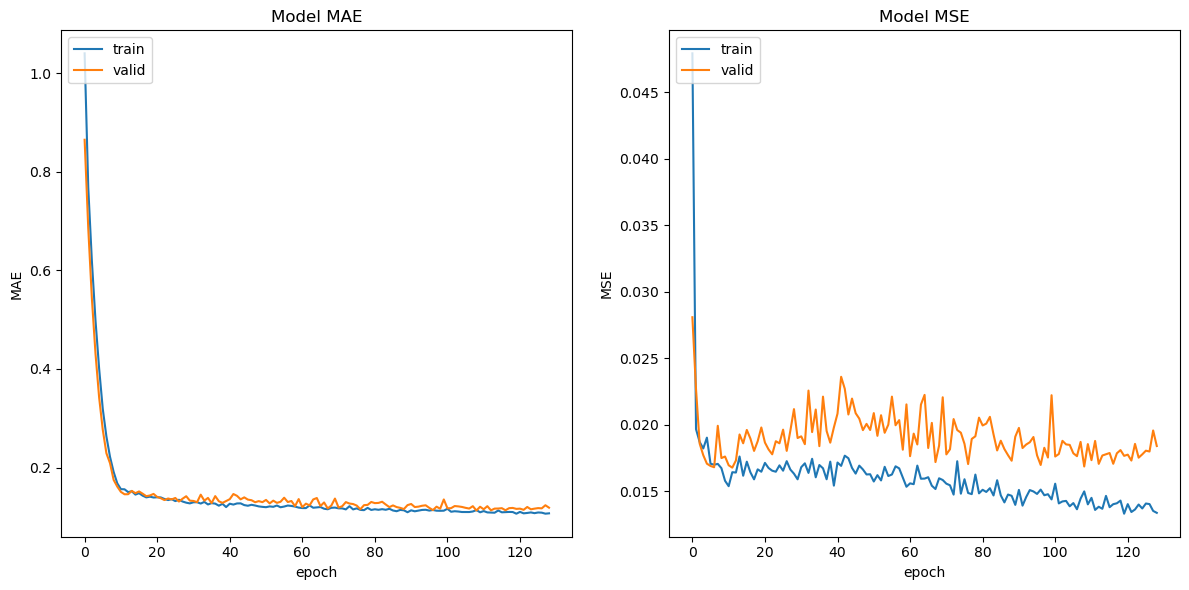

6/6 [==============================] - 0s 2ms/step
Final MAE, MSE, and Coeffiient of determination of Model after reversing scaling====>


,MAE,MAPE,MSE,R_2
LSTMMinMaxScaler(),0.095159,0.25574,0.014441,-0.00618


####################################################################################################


In [66]:
# Set dictionary of hyper-parameter
params = {'layer' : layer,
            'dropouts' : dropouts,
            'optimizer' : optimizer,
            'batch_size' : batch_size
            }

# Define iteration
iteration = 15

# Run model
lstm_result = run_model(scalers, 
          sliding_X_train, sliding_X_val, sliding_X_test,sliding_y_train, sliding_y_val, sliding_y_test,
          params, iteration)

In [75]:
final_results = pd.concat([lasso_result, huber_result, svr_result, rf_result, lstm_result])
final_results

,MAE,MAPE,MSE,R_2
Lasso(alpha=0.01) results,0.307105,0.642594,0.115238,-7.029270
"HuberRegressor(alpha=1, epsilon=1) results",0.432654,0.942779,0.202816,-13.131370
SVR(C=500) results,0.550228,1.216808,0.320048,-21.299616
"RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=4,\n min_samples_split=5, n_estimators=1000) results",0.131332,0.367081,0.025650,-0.787158
LSTMMinMaxScaler(),0.095159,0.255740,0.014441,-0.006180


## ***7- Evaluation***

Based on the metrics, the LSTM model consistently outperforms the other models. It achieves the lowest MAE (0.095), indicating the smallest absolute errors. The RandomForestRegressor follows closely with a slightly higher MAE (0.131), still demonstrating competitive performance. The Lasso model exhibits a moderately higher MAE (0.307), while the HuberRegressor and SVR models yield even higher MAE values (0.433 and 0.550, respectively), indicating less accurate predictions.

Analyzing the MAPE metric, the LSTM model performs the best with the lowest value (0.256), indicating smaller relative errors. The RandomForestRegressor closely follows with a slightly higher MAPE (0.367). The Lasso model exhibits a moderately higher MAPE (0.643), while the HuberRegressor and SVR models yield even higher MAPE values (0.943 and 1.217, respectively), indicating larger relative discrepancies.

In terms of MSE, the LSTM model achieves the lowest value (0.014), indicating superior performance in minimizing squared errors. The RandomForestRegressor follows closely with a slightly higher MSE (0.026). The Lasso model yields a moderately higher MSE (0.115), while the HuberRegressor and SVR models have even higher MSE values (0.203 and 0.320, respectively), indicating larger squared differences.

Considering R², which measures the proportion of the variance explained by the models, the LSTM model exhibits a slightly higher value (-0.006) compared to the RandomForestRegressor (-0.787), suggesting a better fit. The Lasso model yields a significantly lower R² (-7.029), indicating poor fit and unexplained variance. The HuberRegressor and SVR models perform even worse with R² values of -13.131 and -21.300, respectively, indicating poorer fits and significant unexplained variance.

In conclusion, the LSTM model consistently outperforms the other models in predicting the multivariate time series, achieving the lowest MAE, MAPE, and MSE. It also exhibits a slightly higher R² compared to the RandomForestRegressor, indicating a better fit. While the RandomForestRegressor benefits from ensemble learning, it may struggle to capture the complex temporal relationships present in the data as effectively as the LSTM model. The Lasso, HuberRegressor, and SVR models, on the other hand, demonstrate higher errors, larger discrepancies, and poorer fits, indicating their limitations in accurately capturing the underlying patterns in the multivariate time series data.

However, based on the evaluation of the models using MAPE and R² metrics, it can be concluded that none of the models performed exceptionally well in the prediction task. The MAPE values indicate the average percentage difference between the predicted and actual values, with lower values indicating better accuracy. In this case, the LSTM model achieved the lowest MAPE of 0.256, suggesting a relatively lower average error of 25.6% compared to the actual values. 

Furthermore, the R² values provide insights into the models' ability to explain the variance in the data, with values closer to 1 indicating a better fit. Unfortunately, the R² values obtained for all the models, including the LSTM, were relatively low. This implies that the models had difficulty capturing the underlying patterns and explaining the variability present in the data.

# ***8- Probable Reasons for Suboptimal Model Performance***

The evaluation results highlight the need for a thorough investigation of the dataset to uncover the factors behind the modest prediction power. Additionally, careful examination of the utilized methods is crucial as they may have contributed to the identified challenges.

1- The pairplots revealed distinct behaviors of the target variable, anomoly value, across its low, medium, and high values. Additionally, certain features used for prediction exhibited significant variations in their distributions based on the anomaly values, such as emissions and year. Notably, the relationship between the target variable and features like upper_95_ci and global_avg_temp demonstrated an increasing trend, while the relationship with features like year and emission was more complex, showing differing patterns based on the level of emission. These observations highlight the intricate nature of the data, potentially hindering the models' ability to accurately capture the relationships for prediction purposes.

2- It is worth considering the presence of possible outliers within the dataset that were not effectively handled during the study. Despite employing scaling methods and robust models, outliers may still have influenced the model's performance. Identifying and appropriately addressing these outliers could lead to improved predictive accuracy.

3- Another factor to consider is the possibility of suboptimal model performance due to unoptimized model parameters. In this study, due to time and computational limitations, parameter tuning may not have been extensively explored.

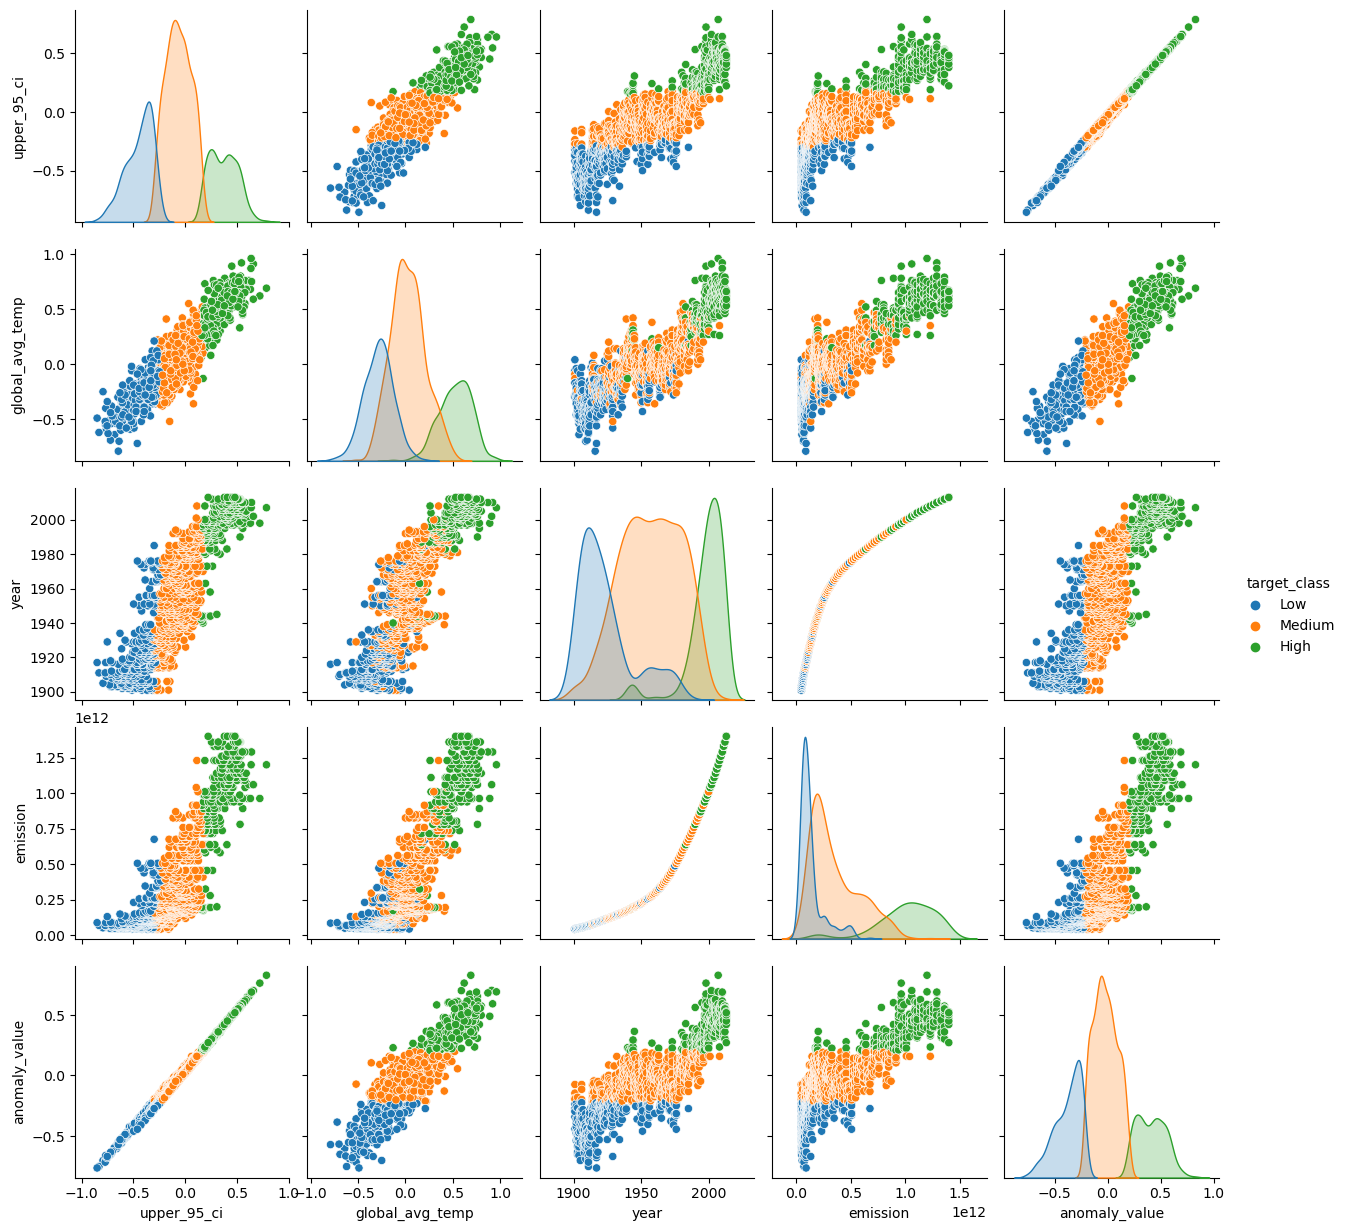

In [77]:
# Determine the thresholds for classifying the target variable
low_threshold = df['anomaly_value'].quantile(0.25)
high_threshold = df['anomaly_value'].quantile(0.75)

# Create a new categorical variable based on the thresholds
final_df['target_class'] = pd.cut(final_df['anomaly_value'], bins=[final_df['anomaly_value'].min(),
                             low_threshold, high_threshold, final_df['anomaly_value'].max()], 
                             labels=['Low', 'Medium', 'High'])

sns.pairplot(final_df, hue='target_class')
plt.show()

## ***9- Future Work***
In the realm of future work, several avenues can be explored to enhance the efficiency and performance of temperature anomaly prediction using a time-series modeling and analysis approach for a three-month ahead forecast.

One aspect that warrants attention is feature engineering. The exploration conducted in the project revealed that each feature exhibits distinct informative lags. However, for the sake of simplicity in modeling, a maximum of 12 lags was considered. To further refine the predictive models, it is advisable to incorporate only the most informative lags for each feature. By doing so, the models can benefit from capturing the essential temporal relationships and potentially yield improved performance.

Additionally, it would be valuable to investigate the applicability of multivariate time series analysis-oriented models. These models, such as Vector Autoregression (VAR), Vector Error Correction Model (VECM), Bayesian Structural Time Series (BSTS), and Gaussian Processes (GP) are designed to handle complex relationships between multiple features and the target variable, in this case, the temperature anomaly value. Furthermore, incorporating the well-known tree-based model XGBoost into the analysis allows for the exploration of complex relationships between the features and the target variable. XGBoost's ability to handle intricate feature interactions and nonlinearity can aid in capturing and leveraging the underlying complexities within the multivariate time series data.

By incorporating these models into the prediction framework, there is an opportunity to capture and leverage intricate interactions and dependencies within the dataset, thereby potentially enhancing the accuracy and robustness of the forecasts.

Furthermore, outlier and anomaly detection can play a significant role in optimizing model performance. By systematically identifying and handling outliers and anomalies in the dataset, while considering their temporal characteristics, it is possible to mitigate their impact on the models. This process may involve employing advanced statistical techniques, such as anomaly detection algorithms tailored for time series data. By appropriately addressing these outliers and anomalies, the models can be better calibrated, leading to more reliable and precise temperature anomaly predictions.